# Gráficas de referencia para exploración de información de bases

En este notebook se realizaron las primeras gráficas de análisis asociadas con las 3 bases de datos, con el objetivo de identificar cuál es la adecuada para el desarrollo de Modelos de Machine Learning basados en ciberseguridad.

Éste está estructurado de la siguiente manera:

1. Base de datos Beth
2. Base de datos CIC-DDoS2019
3. Flow-Based Intrusion Detection Dataset, CIC @UNB Fredericton

Para cada una de ellas se enfocó en los siguientes aspectos:

* **Tratamiento sugerido de datos (Beth):** De acuerdo con lo comentado en el artículo de referencia, se revisaron las transformaciones sugeridas a las variables.
* **Variables Categóricas:** Se realizaron gráficos de barras para identificar la distribución de acuerdo con las etiquetas de ataques.
* **Variables Numéricas:** A partir de boxplots se identificaron las diferentes tendencias de acuerdo con el tipo de ataque.
* **Correlación:** Para las dos bases obtenidas de University of New Brunswick se realizó un análisis adicional de correlación entre variables, para identificar posibles ajustes y de la viabilidad de realización del modelo de ML.
* **Tablas consolidadas:** Creación de tablas con el resumen de la distribución de las variables.

A partir de este insumo, el objetivo es proceder a actualizar el documento con los principales insights del ejercicio.


In [ ]:
# Montado de drive para realizar el análisis
from google.colab import drive
drive.mount('/content/drive') #Comentar

Mounted at /content/drive


In [ ]:
#Librerías Utilizadas
import pandas as pd # Manipulación de datos
pd.options.display.float_format = '{:.1f}'.format #Adecuar formato de salidas de tablas a 1 posición decimal
import seaborn as sns # Creación de gráficas
import matplotlib.pyplot as plt # Formato de gráficas

# 1. Base de datos BETH

En primera instancia, se hace el cargado de la base consolidada realizada en ejercicios anteriores:

In [ ]:
#Cargado de información BETH
data_beth=pd.read_parquet("/content/drive/MyDrive/Tesis - Machine Learning/Tesis - Machine Learning/B - bases de datos/Análisis Abril 2024/Bases Consolidadas/Total_BETH.parquet")

In [ ]:
#Forma de la base
data_beth.shape

(2466896, 13)

Se identifica que la base no tiene el total de registros reportados por los autores, llegando a un total de más de 2 millones de registros. A su vez, se analizó la distribución de los campos asociados con `processId`, para reconocer si tienen alguna usabilidad, ya que los autores lo refieren como números generados al azar. A primera vista, para ambas variables se ve este comportamiento:

In [ ]:
display(data_beth[["timestamp","processId"]].groupby(by="processId").count().reset_index().sort_values(by="timestamp",ascending=False).head(5))

processId  timestamp
6          159     158148
0            1      47804
27         506      10526
871       8046       7812
601       7776       7569

In [ ]:
data_beth[["timestamp","parentProcessId"]].groupby(by="parentProcessId").count().reset_index().sort_values(by="timestamp",ascending=False).head(5)

parentProcessId  timestamp
51             7096     287450
1                 1     255531
66             7320     133656
44             1567     118286
45             1570     107682

Posteriormente, se realizó la revisión del campo de `UserId`, y se identifica que la mayoría de registros se encuentran en 0, a la vez que hay un total de 9 usuarios, aspecto que hace candidata a la variable para la transformación en categórica:

In [ ]:
data_beth[["timestamp","userId"]].groupby(by="userId").count().reset_index().sort_values(by="timestamp",ascending=False).head(20)

userId  timestamp
0       0    2405884
5     105      15711
2     101      11129
8    1001      10019
4     104       8619
6     109       8001
1     100       4300
7    1000       2844
3     103        389

In [ ]:
#Selección de registros
categorias = data_beth['userId'].unique()
# Creación de diccionario para mapear los valores únicos a etiquetas numéricas
diccionario_etiquetas = {valor: indice + 1 for indice, valor in enumerate(categorias)}
# Aplicación de mapeo para ajustes
data_beth['userId_cat'] = data_beth['userId'].map(diccionario_etiquetas)

Un análisis similar se realizó para la Variable de `returnValue`, donde se identificó que la mayoría son 0, mientras que los demás corresponden a valores menores o mayores que 0

In [ ]:
data_beth[["timestamp","returnValue"]].groupby(by="returnValue").count().reset_index().sort_values(by="timestamp",ascending=False)

returnValue  timestamp
11              0    1735811
20              9     418993
14              3      89466
9              -2      64159
19              8      28438
...           ...        ...
1476         8621          1
1475         8620          1
1474         8619          1
1472         8617          1
1310         8453          1

[1760 rows x 2 columns]

Por ello, se agruparon estas variables entre positivas, negativas y 0. Luego, se identificó la distribución en los registros:

In [ ]:
def asignar_valor(valor):
    if valor == 0:
        return 0
    elif valor < 0:
        return -1
    else:
        return 1
data_beth['returnValue_new'] = data_beth['returnValue'].apply(lambda x: asignar_valor(x))

In [ ]:
data_beth[["timestamp","returnValue_new"]].groupby(by="returnValue_new").count().reset_index().sort_values(by="timestamp",ascending=False)

returnValue_new  timestamp
1                0    1735811
2                1     652642
0               -1      78443

Finalmente en este apartado se hace la eliminación de las columnas antes de tratamiento y se definen a todas las columnas, a excepción de `timestamp`, como texto, ya que se mencionó que varias de estas columnas corresponden a valores generados al azar

In [ ]:
# Base tratada
data_beth_fin=data_beth.drop(columns=["userId","returnValue"]).rename(columns={"userId_cat":"userId","returnValue_new":"returnValue"})

for i in data_beth_fin.select_dtypes(include=['number']).columns:
  if i == "timestamp":
    pass
  else:
    data_beth_fin[i]=data_beth_fin[i].astype("object")

In [ ]:
data_beth_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466896 entries, 0 to 2466895
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   timestamp        float64
 1   processId        object 
 2   parentProcessId  object 
 3   processName      object 
 4   hostName         object 
 5   eventId          object 
 6   eventName        object 
 7   argsNum          object 
 8   args             object 
 9   sus              object 
 10  evil             object 
 11  userId           object 
 12  returnValue      object 
dtypes: float64(1), object(12)
memory usage: 244.7+ MB


## 1.1. Creación de gráficas de análisis

Para la construcción de gráficas se filtraron las columnas categóricas, con el objetivo de realizar un bucle para ver el comportamiento de las variables con respecto a la predicción

In [ ]:
# Selección de columnas
cols_cat=list(data_beth_fin.select_dtypes(include=['object',"category"]).columns)
# Eliminar las columnas de las etiquetas
cols_cat.remove("sus")
cols_cat.remove("evil")

Específicamente, se construyó una tabla intermedia en la cual se filtran las 5 categorías con mayor cantidad de registros por variable en el etiquetado de no sospechoso `sus=0` y luego se generan diagramas de barras para ver si hay una relación entre estos registros y este valor:

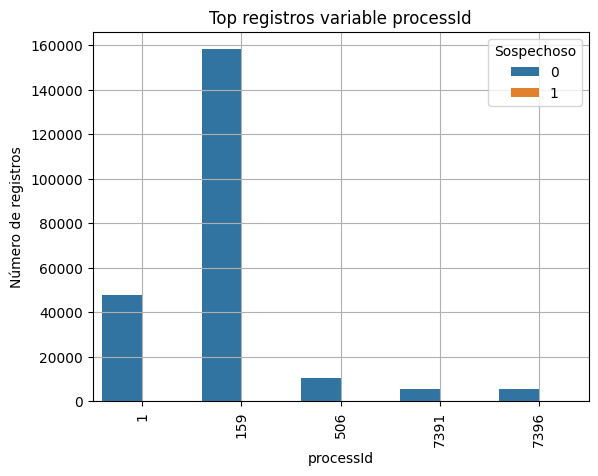

####################################################################################################


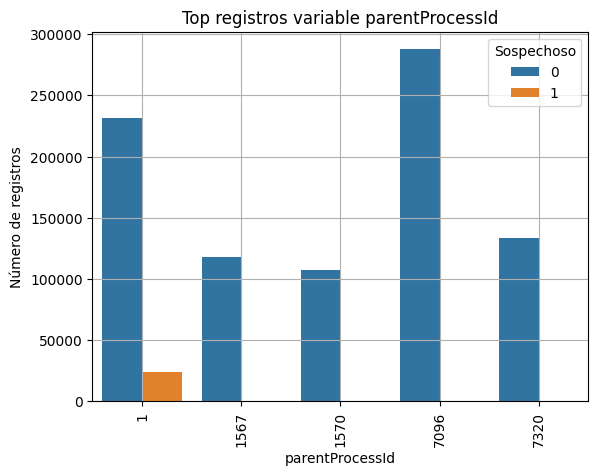

####################################################################################################


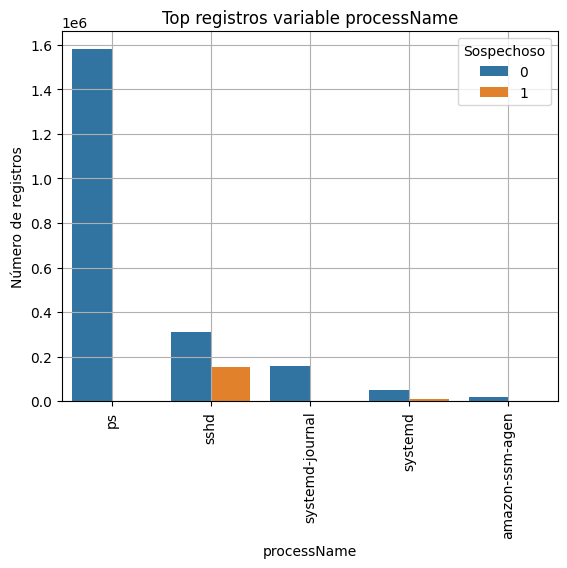

####################################################################################################


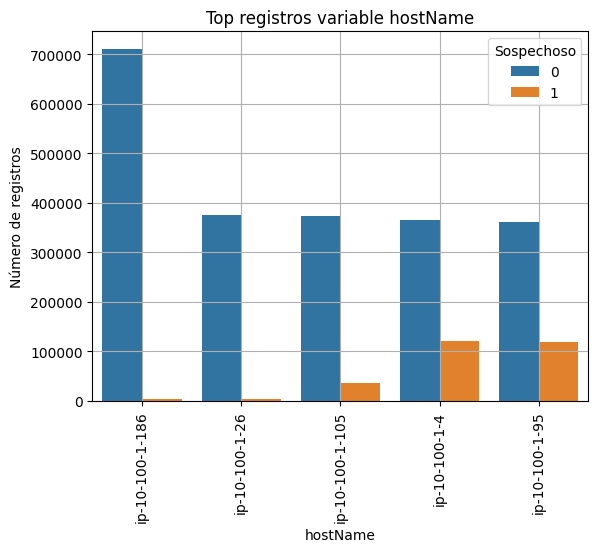

####################################################################################################


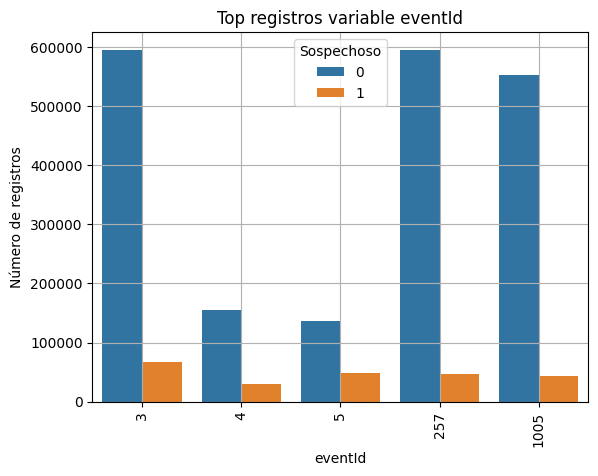

####################################################################################################


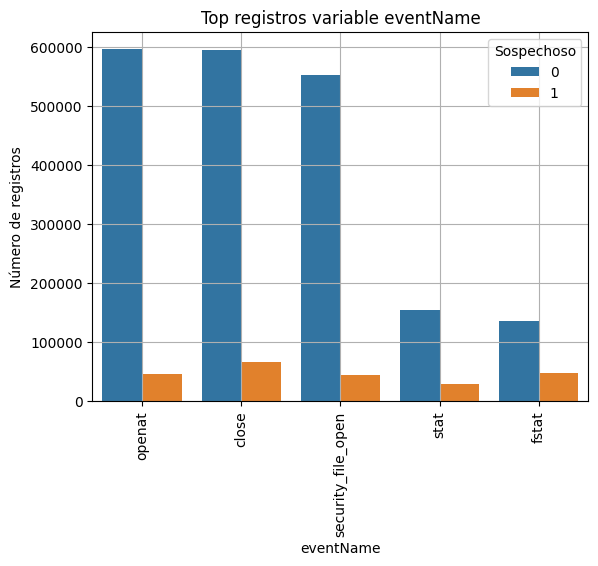

####################################################################################################


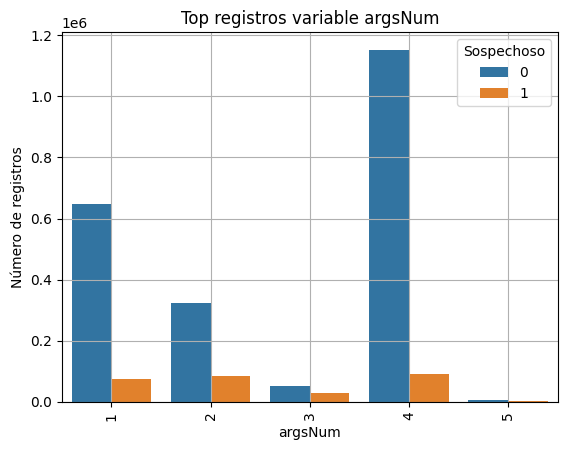

####################################################################################################


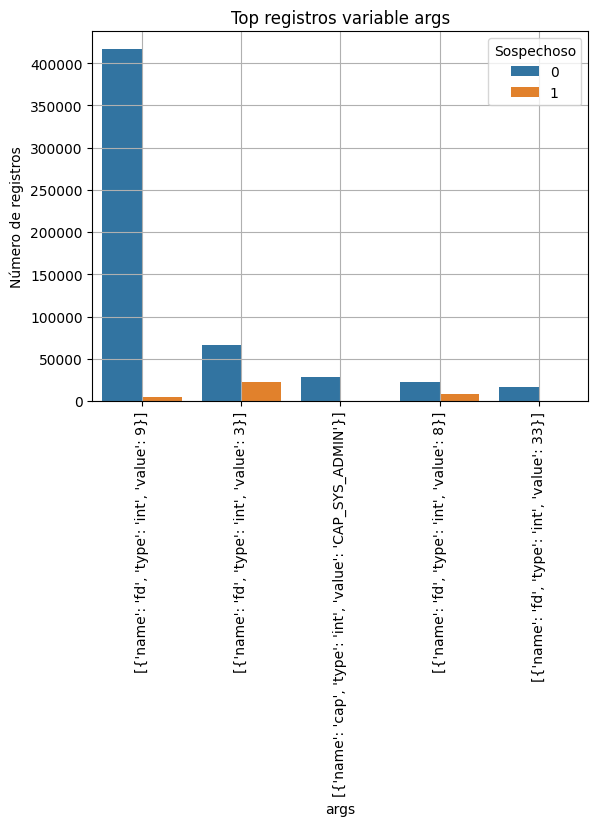

####################################################################################################


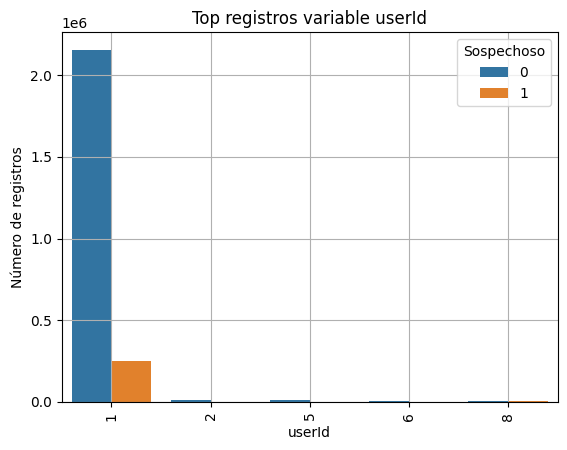

####################################################################################################


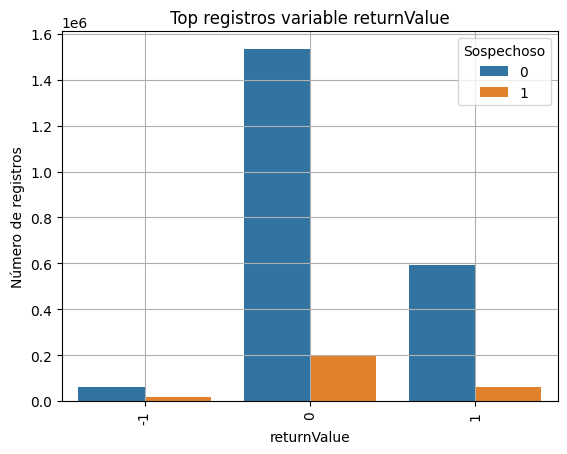

####################################################################################################


In [ ]:
for i in cols_cat:
  # Filtro de tabla para sólo considerar la columna y etiqueta de sospechoso
  data_lim=data_beth_fin[[i,"sus"]]
  # Listado de categorías
  filter=list(data_lim[data_lim["sus"]==0].value_counts().sort_values(ascending=False).reset_index()[i][:5])
  # Filtro de tabla resumida con las respectivas categorías
  df_test= data_beth_fin[data_beth_fin[i].isin(filter)][[i,"sus"]].value_counts().reset_index().sort_values(by=["sus"])
  nombre_var=i
  # Creación de gráfica
  sns.barplot(df_test,x=i,y="count",hue="sus")
  # Formato de gráfica
  plt.grid()
  plt.xticks(rotation=90)
  plt.ylabel("Número de registros")
  plt.title(f"Top registros variable {nombre_var}")
  plt.legend(title="Sospechoso")
  plt.show()
  print("#"*100)


A continuación se presentan los análisis por variable:

* **processId:** En los procesos con mayor cantidad de no sospechosos hay poca o nula cantidad de procesos sospechosos, lo que la hace clave para el desarrollo de la predicción.
* **parentProcessId:** Sólo en unos de los 5 registros tiene un etiquetado de sospechoso
* **processName:** En sshd y en menor medida systemd tienen registros sospechosos, aspectos clave para la clasificación.
* **HostName:** Correspondiente a las simulaciones realizadas, cada IP tiene un comportamiento en particular.
* **EventId y EventName:** Representan la misma información, tal como se puede apreciar en las gráficas, en conjunto mostrando que cada uno tiene un número de ataques sospechosos
* **argNum:** Se identifica que hay una cantidad de registros sospechosos en forma proporcial a los no sospechosos
* **userId y returnValue:** De acuerdo con la transformación dada, en estas variables no se identifica una tendencia clara

Posteriormente se identificaron los valores cuando la etiqueta sospechosa es igual a 1:

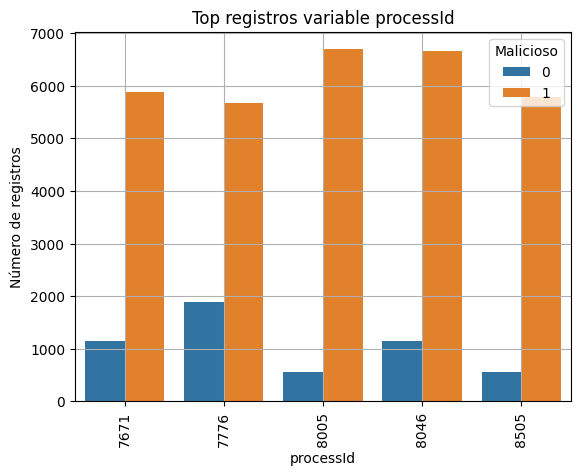

####################################################################################################


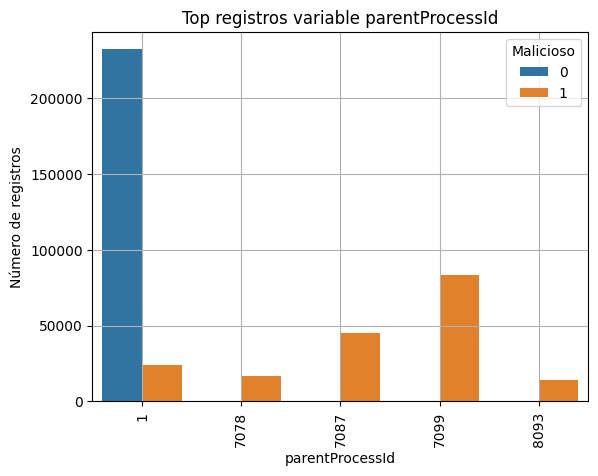

####################################################################################################


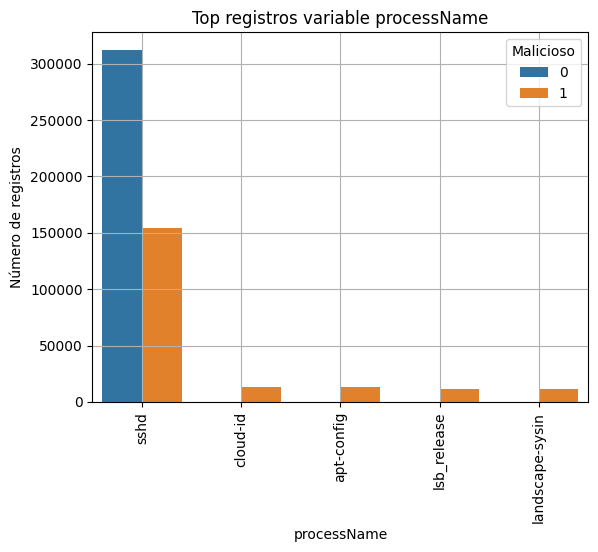

####################################################################################################


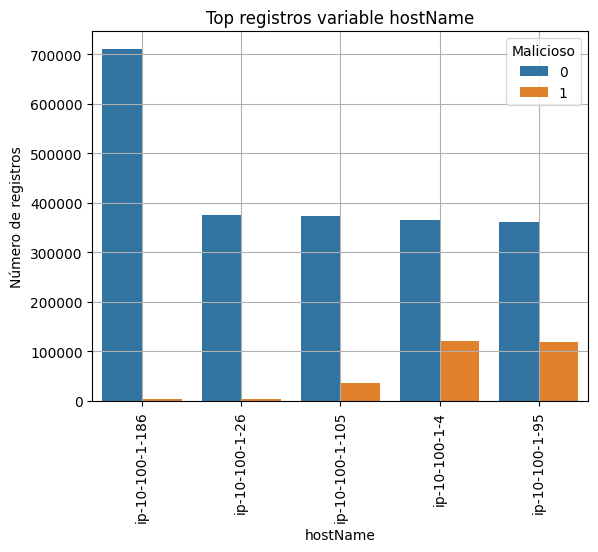

####################################################################################################


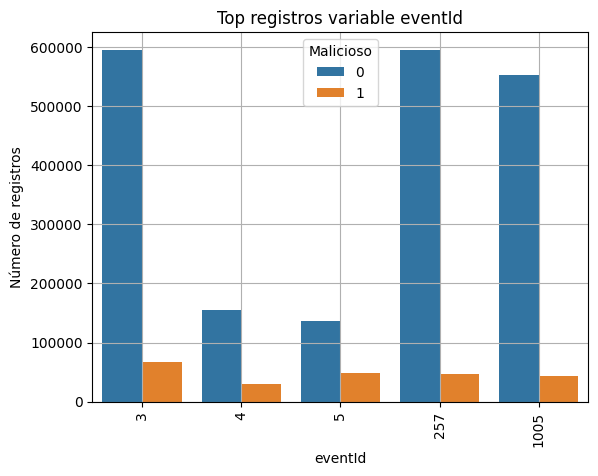

####################################################################################################


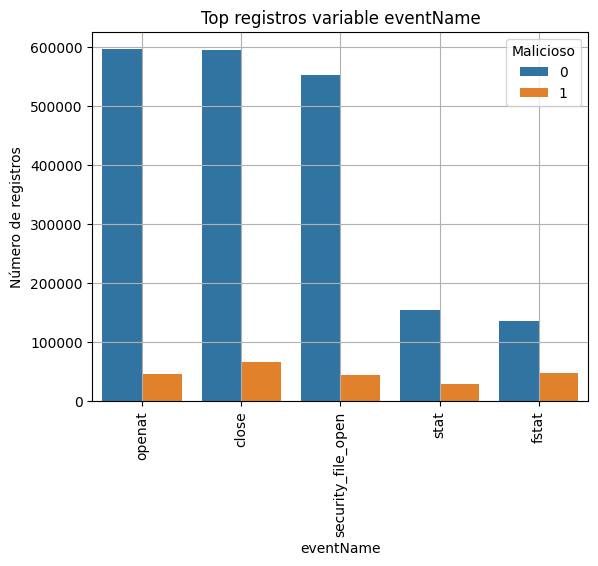

####################################################################################################


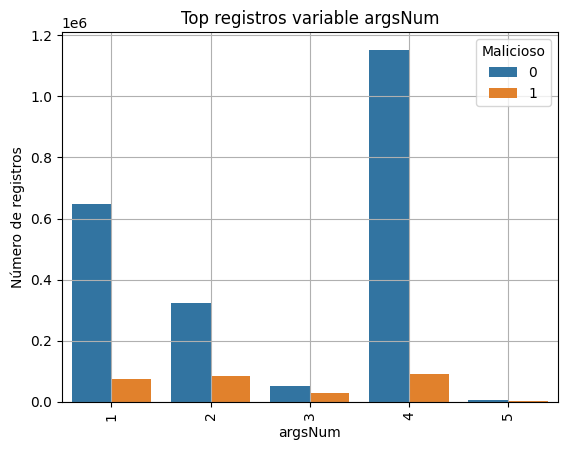

####################################################################################################


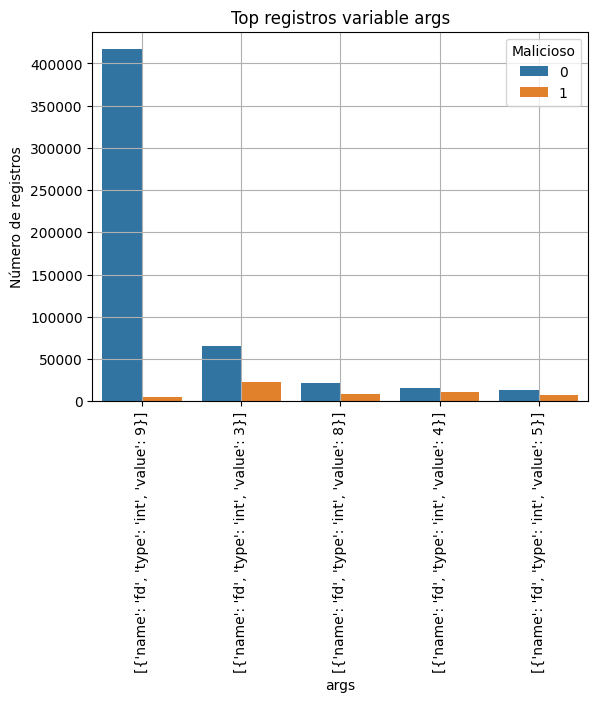

####################################################################################################


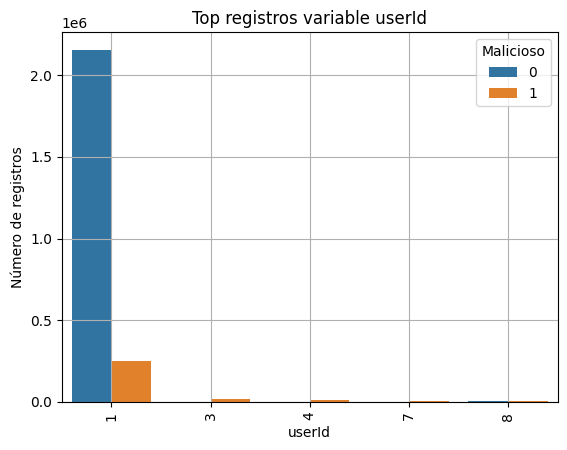

####################################################################################################


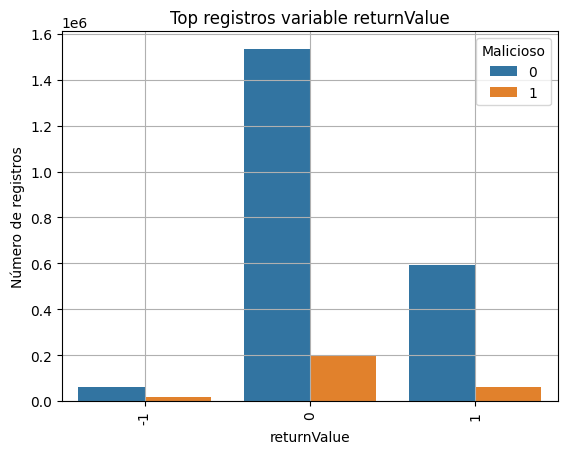

####################################################################################################


In [ ]:
for i in cols_cat:
  data_lim=data_beth_fin[[i,"sus"]]
  filter=list(data_lim[data_lim["sus"]==1].value_counts().sort_values(ascending=False).reset_index()[i][:5])
  df_test= data_beth_fin[data_beth_fin[i].isin(filter)][[i,"sus"]].value_counts().reset_index().sort_values(by=["sus"])
  nombre_var=i
  sns.barplot(df_test,x=i,y="count",hue="sus")
  plt.grid()
  plt.xticks(rotation=90)
  plt.ylabel("Número de registros")
  plt.title(f"Top registros variable {nombre_var}")
  plt.legend(title="Malicioso")
  plt.show()
  print("#"*100)


A continuación se presentan los análisis por variable:

* **processId:** Como contraste con respecto al apartado anterior, se identifican procesos que en su mayoría corresponden a ataques sospechosos, aspecto clave para la clasificación.
* **parentProcessId:** De la misma manera, hay valores en donde es exclusivo los ataques.
* **processName:** En sshd tiene una amplia cantidad de registros como sospechos mientras los demás presentan exlusivamente eventos sospechosos.
* **HostName:** No varia con respecto al caso anterior
* **EventId y EventName:** De forma similar, con respecto a Host Name no varia
* **argNum:** No varian con respecto al caso anterior
* **userId y returnValue:** No varian con respecto al caso anterior

Como complemento, se muestra la distribución de todas las variables, identificando que, a excepcion de `args`, `processId` y `parentProcessId` cada elemento tiene menos de 50 valores únicos, aspecto clave para la construcción de un eventual modelo de ML.

In [ ]:
data_beth_fin.describe(include=['O'])

processId  parentProcessId processName         hostName  eventId  \
count     2466896          2466896     2466896          2466896  2466896   
unique       1717              947         137                5       48   
top           159             7096          ps  ip-10-100-1-186        3   
freq       158148           287450     1580971           713867   661662   

       eventName  argsNum                                         args  \
count    2466896  2466896                                      2466896   
unique        48        6                                      1160745   
top        close        4  [{'name': 'fd', 'type': 'int', 'value': 9}]   
freq      661662  1243937                                       421349   

            sus     evil   userId  returnValue  
count   2466896  2466896  2466896      2466896  
unique        2        2        9            3  
top           0        0        1            0  
freq    2184612  2456891  2405884      1735811

Por último, el campo de `timestamp`, debido a cómo se construyó la base, no representa información clave para el análisis, en especial considerando posible escalabilidad de la solución a otros entornos.

In [ ]:

data_beth_fin.describe(exclude=['O'])

timestamp
count  2466896.0
mean      9656.3
std       5028.3
min        124.4
25%       5383.3
50%      10161.9
75%      14087.4
max      18887.2

# 2. CIC 2019

Para esta segunda base primero se hizo el cargue de la tabla consolidada, para identificar la cantidad de columnas disponibles y de información.

En este primer vistazo se identifica que la mayor parte de registros corresponden a valores numéricos:

In [ ]:
df_CIC2019 = pd.read_parquet("/content/drive/MyDrive/Tesis - Machine Learning/Tesis - Machine Learning/B - bases de datos/Análisis Abril 2024/Bases Consolidadas/Total_CICDDoS2019.parquet")

In [ ]:
df_CIC2019.head()

Protocol  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0        17             48                  4                       0   
1        17            557                112                       0   
2         6         323228                 14                      12   
3        17          46917                  2                       2   
4        17            254                 58                       0   

   Fwd Packets Length Total  Bwd Packets Length Total  Fwd Packet Length Max  \
0                    1616.0                       0.0                  440.0   
1                   49280.0                       0.0                  440.0   
2                    1736.0                     526.0                  602.0   
3                      86.0                     118.0                   43.0   
4                   25520.0                       0.0                  440.0   

   Fwd Packet Length Min  Fwd Packet Length Mean  Fwd Packet Length Std  ...  \
0                  368.0                   404.0                   41.6  ...   
1                  440.0                   440.0                    0.0  ...   
2                    0.0                   124.0                  211.3  ...   
3                   43.0                    43.0                    0.0  ...   
4                  440.0                   440.0                    0.0  ...   

   Fwd Seg Size Min  Active Mean  Active Std  Active Max  Active Min  \
0                20          0.0         0.0         0.0         0.0   
1                 0          0.0         0.0         0.0         0.0   
2                20          0.0         0.0         0.0         0.0   
3                20          0.0         0.0         0.0         0.0   
4                -1          0.0         0.0         0.0         0.0   

   Idle Mean  Idle Std  Idle Max  Idle Min      Label  
0        0.0       0.0       0.0       0.0  DrDoS_NTP  
1        0.0       0.0       0.0       0.0  DrDoS_NTP  
2        0.0       0.0       0.0       0.0     Benign  
3        0.0       0.0       0.0       0.0     Benign  
4        0.0       0.0       0.0       0.0  DrDoS_NTP  

[5 rows x 78 columns]

Posteriormente, se identificó el nombre de las columnas en la conformación de la base. A primera vista, se muestra que hay varios grupos de variables que están agrupadas a partir de distintas medidas de dispersión como Mínimos, Máximos, Desviación Estandar y Media:

In [ ]:
df_CIC2019.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Fla

Adicional, se identifica que en esta dataset están disponibles 431371 registros, cada uno con 78 variables.

In [ ]:
df_CIC2019.shape

(431371, 78)

Por ello, se crearon listas con los indicadores para reconocer el comportamiento característico de acuerdo con el ataque. Como estas corresponden a variables numéricas se optó por utilizar boxplot. En este primer acercamiento, se escogió no considerar los outliers para ver claramente las tendencias:

In [ ]:
#Variables con varios indicadores
List_val=["Fwd Packet Length","Bwd Packet Length","Flow IAT",
          "Fwd IAT","Bwd IAT","Packet Length","Bytes/Bulk","Packets/Bulk","Active","Idle"]

In [ ]:
#Listado de variables
List_tot=[i for i in df_CIC2019.columns if "total" in i.lower()]
List_Max=[i for i in df_CIC2019.columns if "max" in i.lower()]
List_Min=[i for i in df_CIC2019.columns if "min" in i.lower()]
List_Mean=[i for i in df_CIC2019.columns if "mean" in i.lower()]

Se graficaron las variables de tipo "Total", y en ellas se identifica que de acuerdo al ataque hay unas en las que hay un aumento importante mientras que en los demás se mantiene en 0 o en valores muy pequeños con respecto a los demás ataques.

Por ejemplo, para la variable de **Total Backward Packages** se identifica un comportamiento anomalo en los registros benignos, Syn y WebDDos, aspectos clave en momento de clasificación.

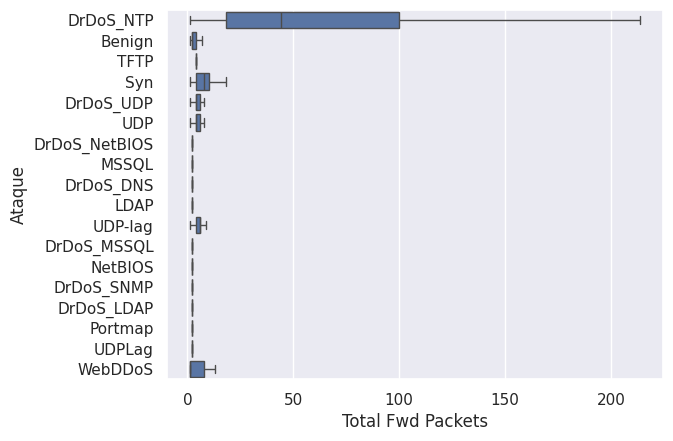

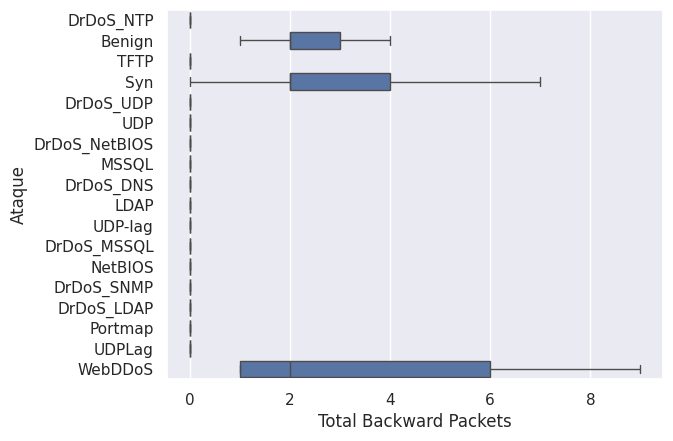

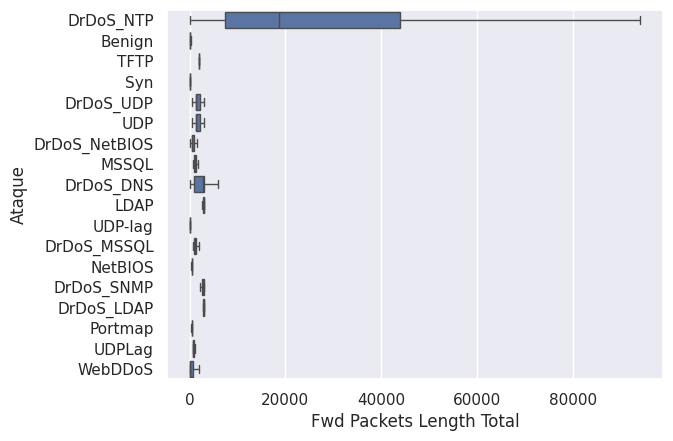

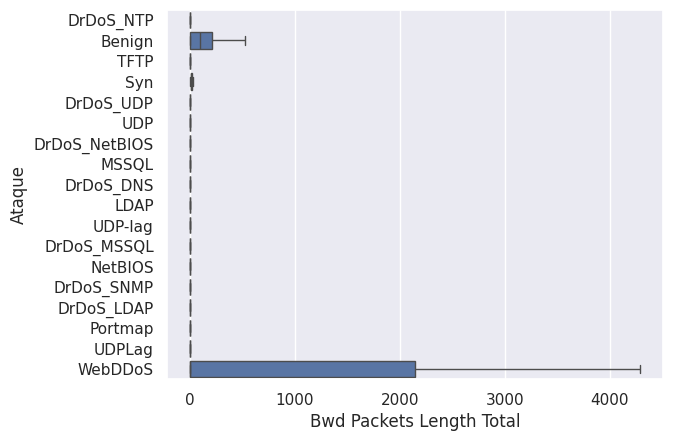

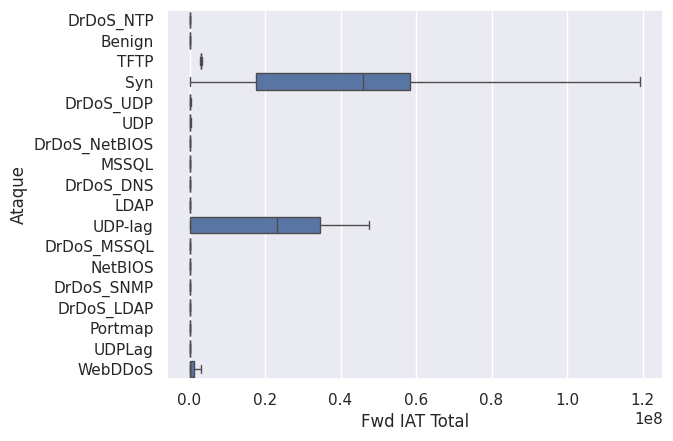

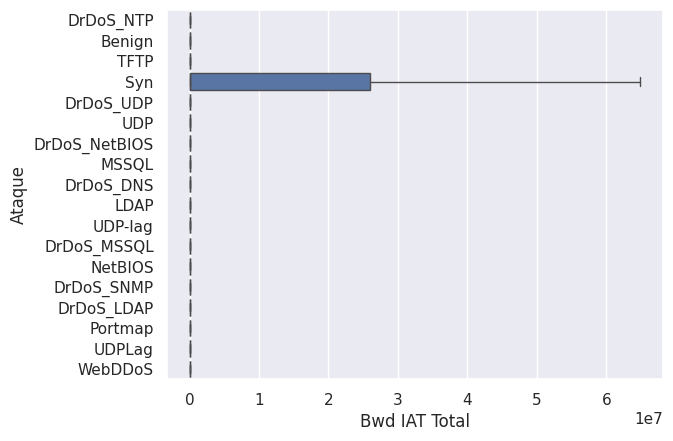

In [ ]:
for i in List_tot:
  sns.set_theme(style="darkgrid")
  sns.boxplot(data=df_CIC2019, x=i, y="Label", showfliers=False)
  plt.ylabel("Ataque")
  plt.show()

Al considerar los outliers, se ve que por sus valores no permiten ver la distribución de acuerdo con el tipo de ataque, aspecto a considerar en el momento de construcción de los respectivos modelos de ML

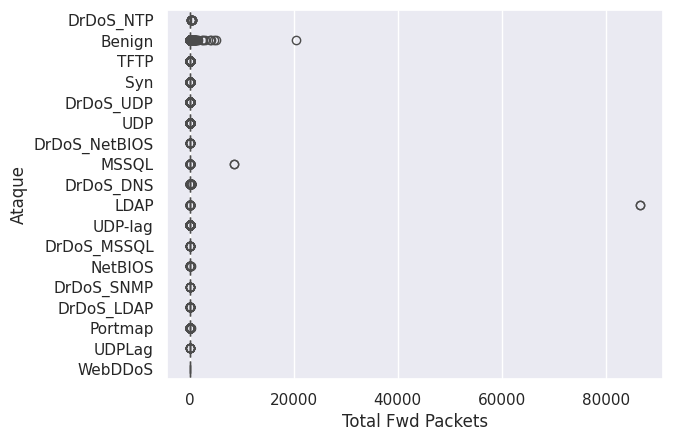

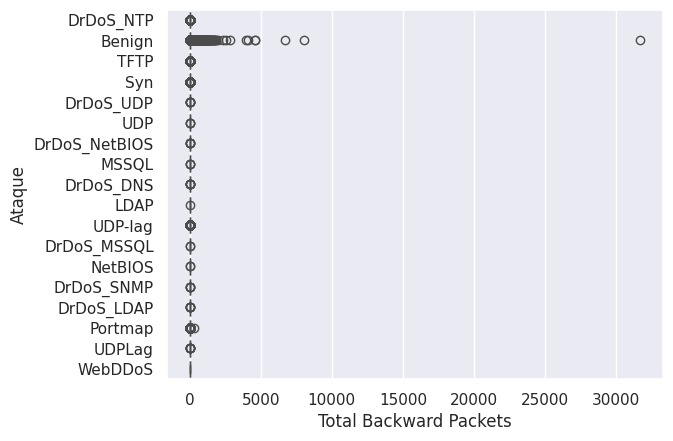

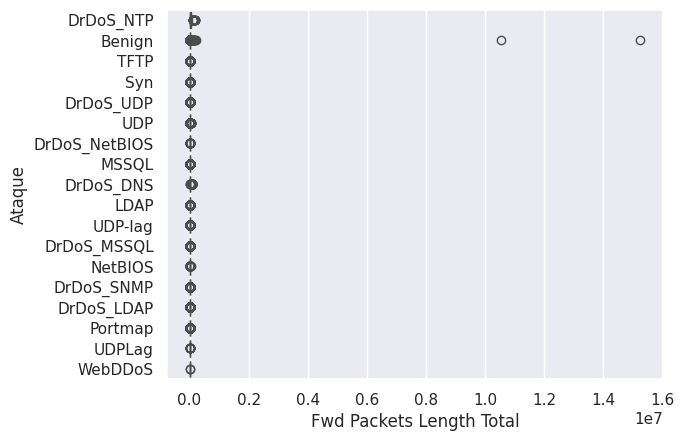

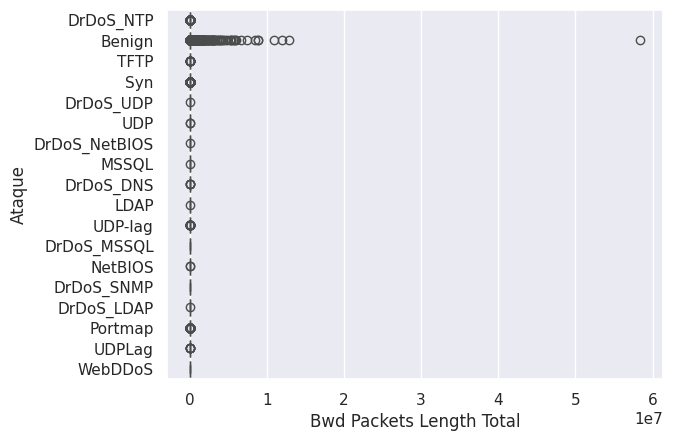

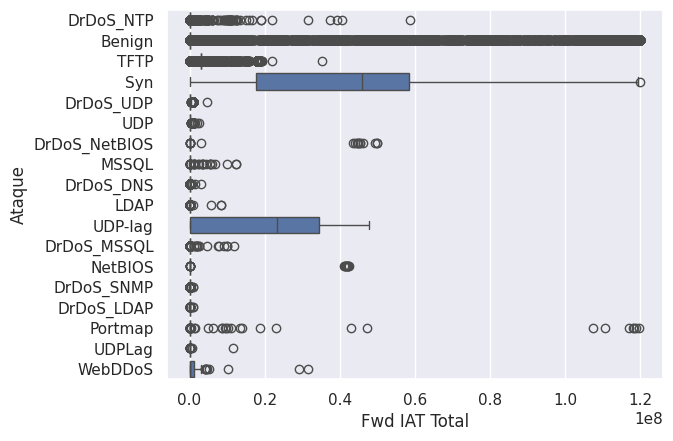

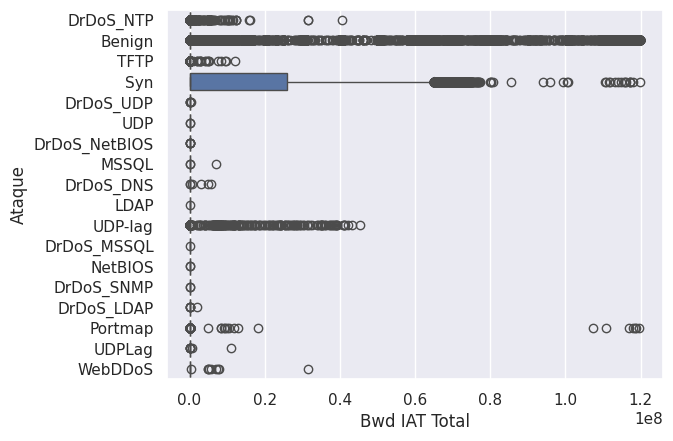

In [ ]:
for i in List_tot:
  sns.set_theme(style="darkgrid")
  sns.boxplot(data=df_CIC2019, x=i, y="Label")
  plt.ylabel("Ataque")
  plt.show()

Posteriormente, al analizar las gráficas de valor máximo, se identifica que estas distribuciones cambian, siendo por ejemplo en la variable de `Fwd Packet Length Max` presentando diferentes distribuciones de acuerdo al tipo de ataque:

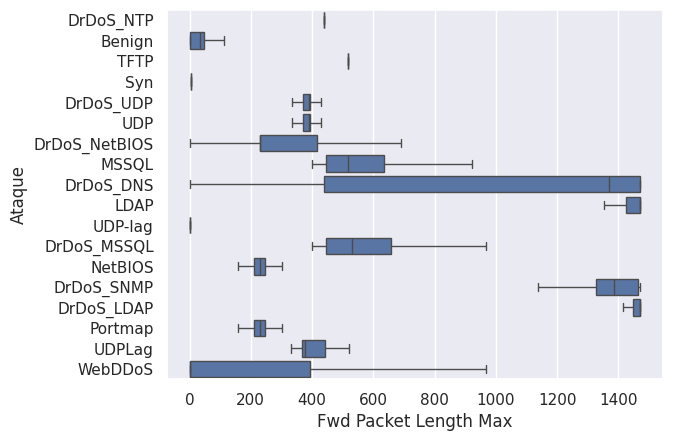

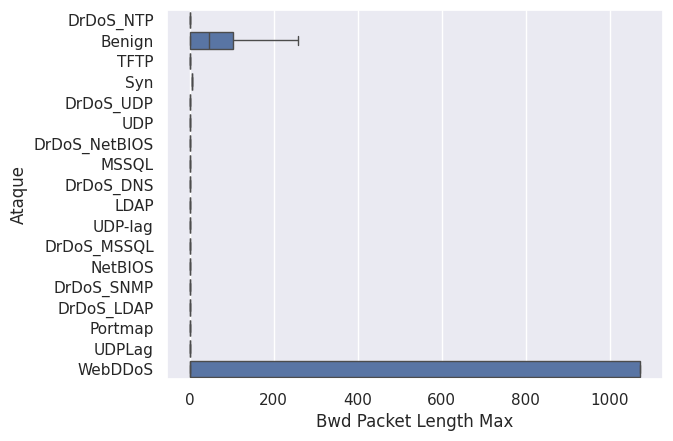

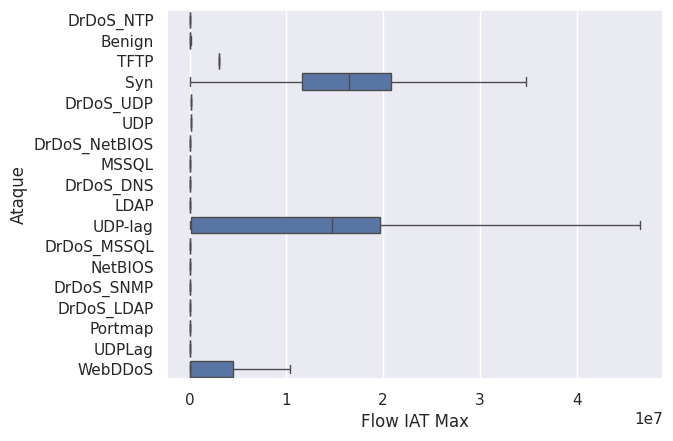

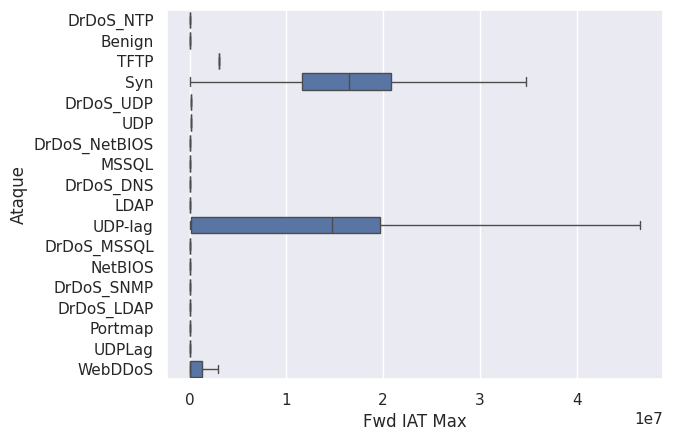

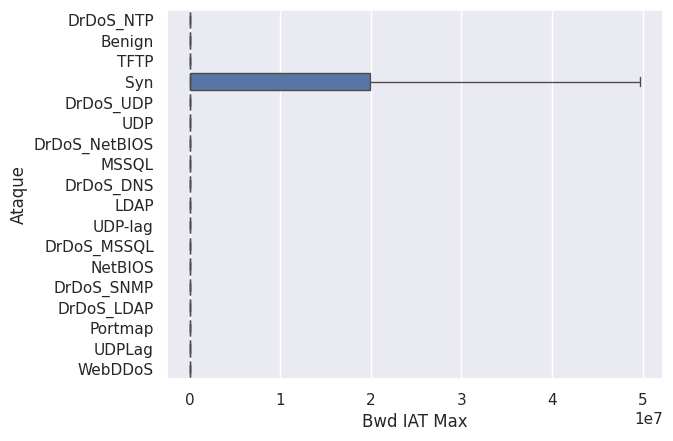

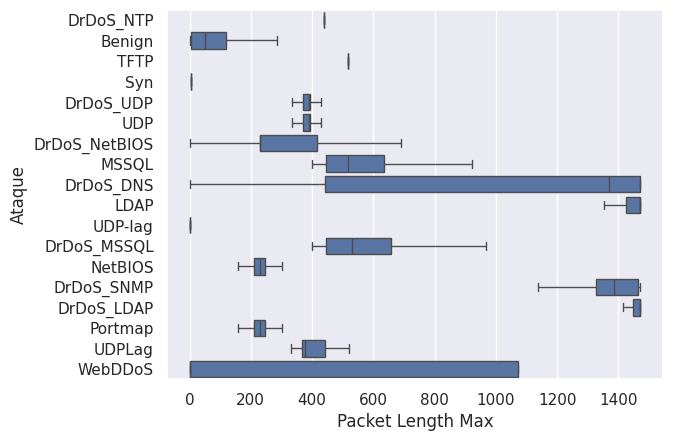

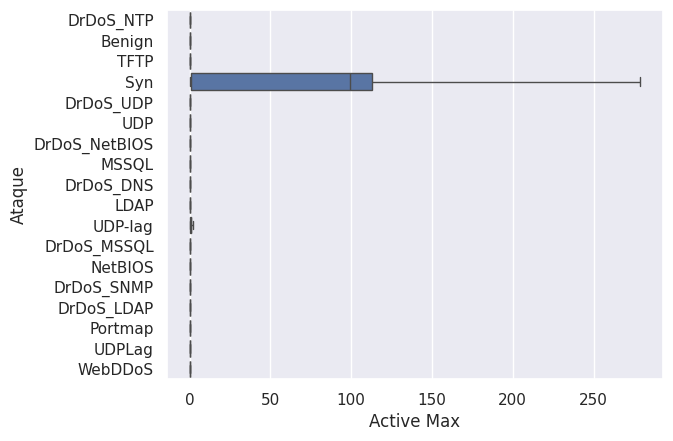

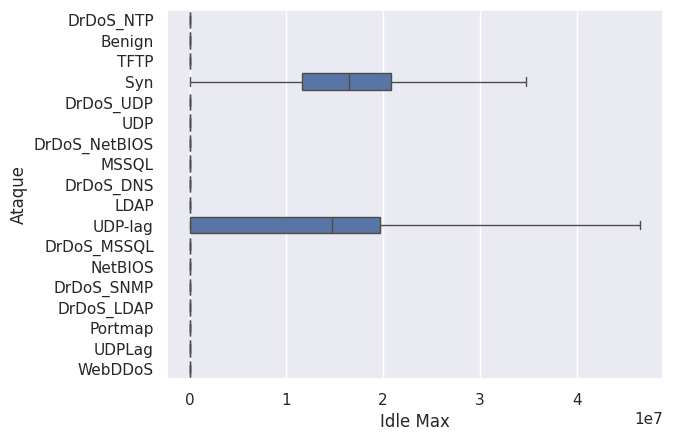

In [ ]:
for i in List_Max:
  sns.boxplot(data=df_CIC2019, x=i, y="Label", showfliers=False)
  plt.ylabel("Ataque")
  plt.show()

De forma similar, en el campo de la media, se identifica una tendencia similar a los valores máximos, donde para cada uno de los ataques se evidencia un comportamiento diferenciado, si bien en varias de estas métricas los valores se acercan a 0.

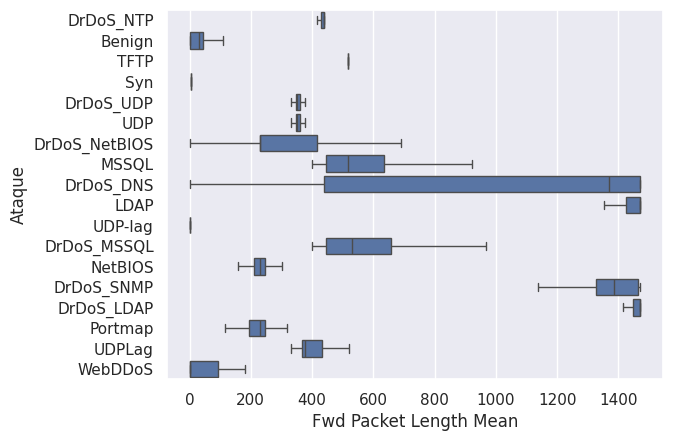

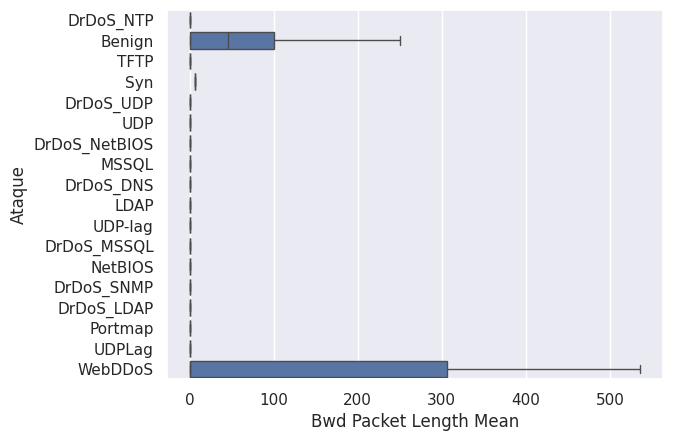

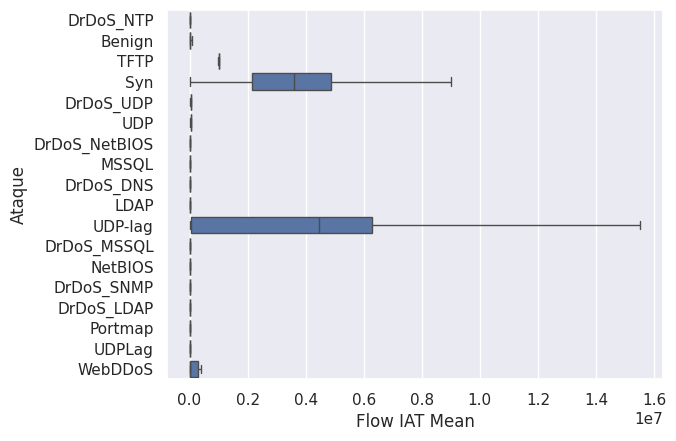

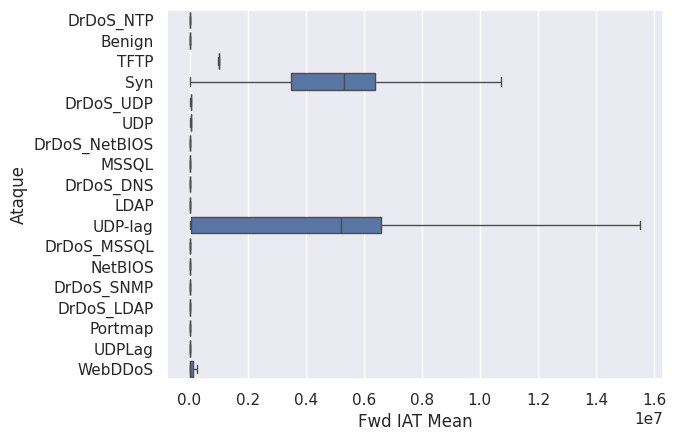

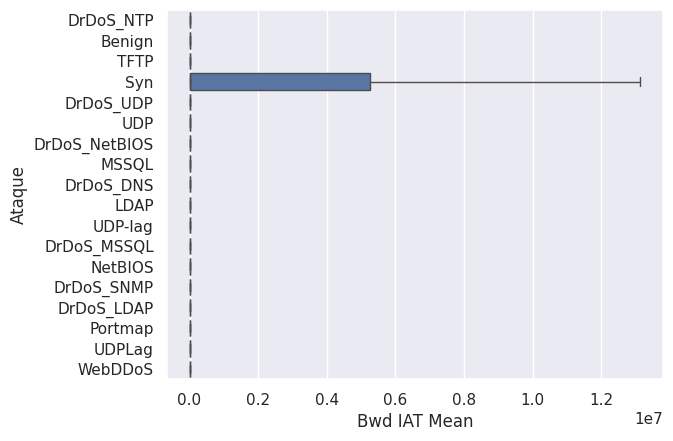

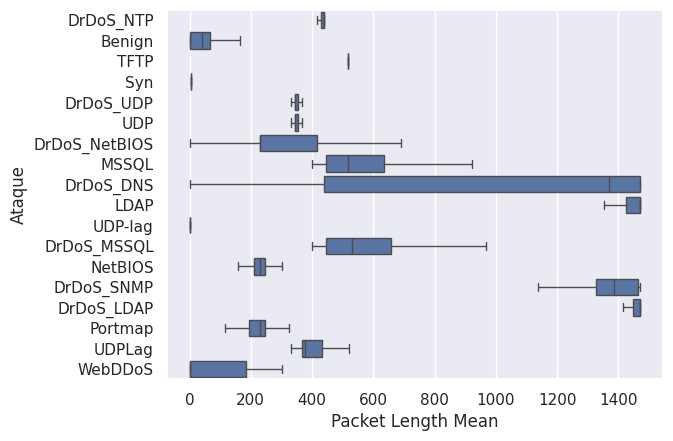

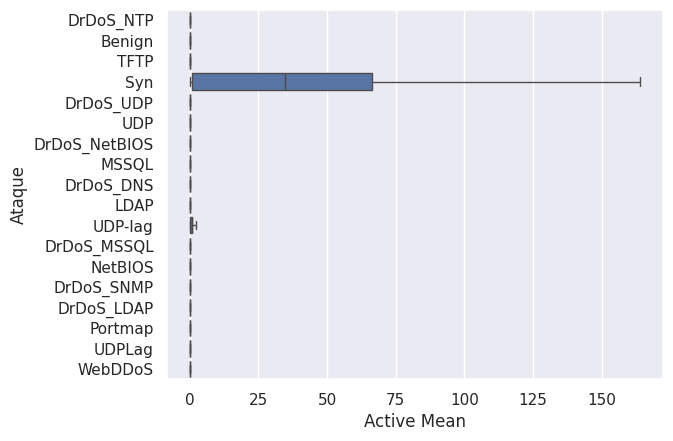

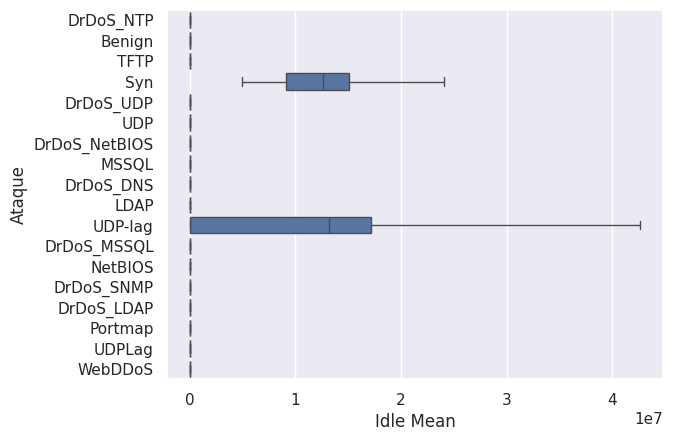

In [ ]:
for i in List_Mean:
  sns.boxplot(data=df_CIC2019, x=i, y="Label", showfliers=False)
  plt.ylabel("Ataque")
  plt.show()

Como punto adicional, se compararon los campos que contienen el nombre de `fwd packet length`, donde se identifica que en 3 de las 4 variables la tendencia es prácticamente la misma, dando como principal insight de que estos valores están correlacionados

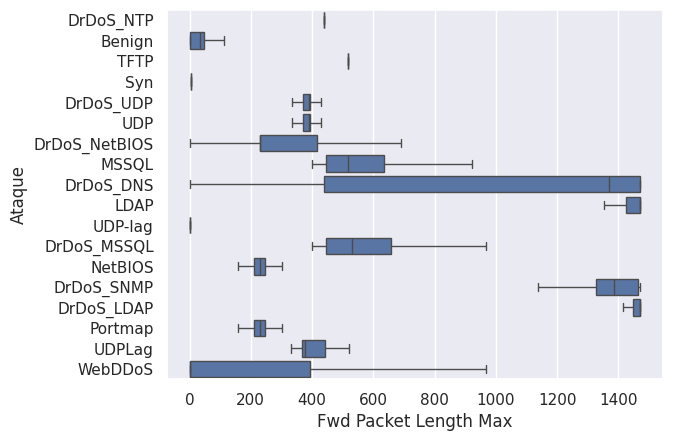

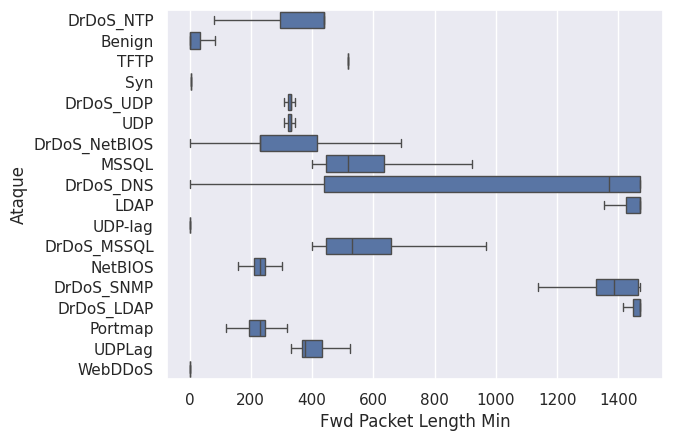

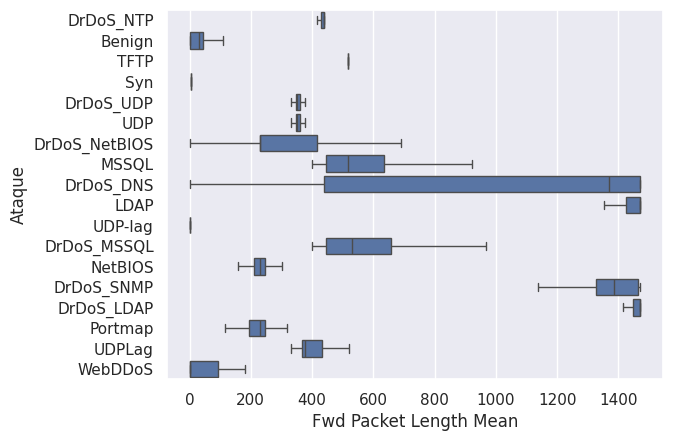

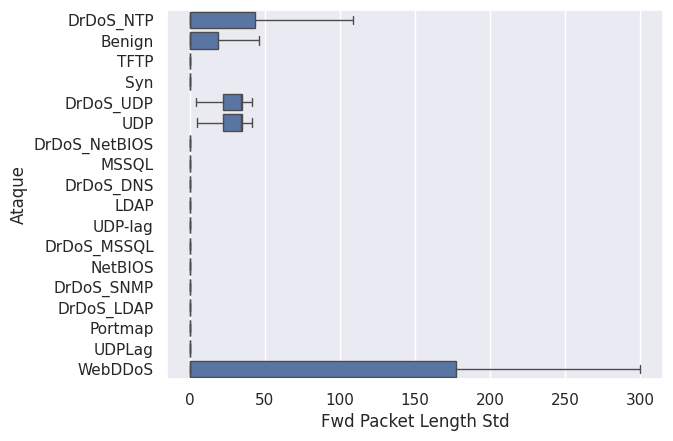

In [ ]:
# Comparación entre variables del mismo nombre:
List_Same=[i for i in df_CIC2019.columns if "fwd packet length" in i.lower()]
for i in List_Same:
  sns.boxplot(data=df_CIC2019, x=i, y="Label", showfliers=False)
  plt.ylabel("Ataque")
  plt.show()

Para las variables del campo `subrow` por otro lado, se ven comportamientos diferentes ya que consideran tanto bytes como paquetes, haciendo que las correspondientes a Fwd tengan una distribución similar

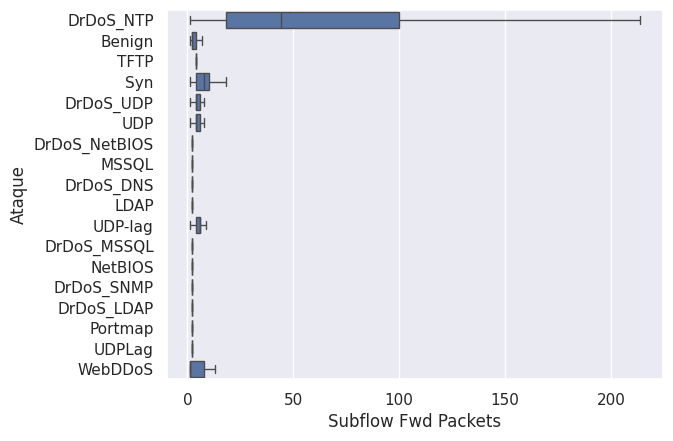

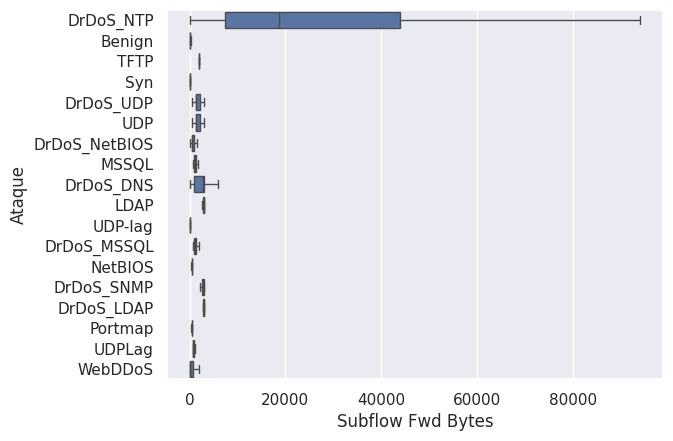

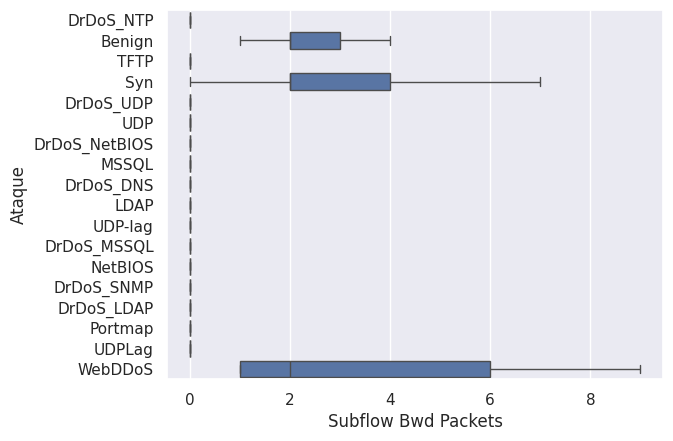

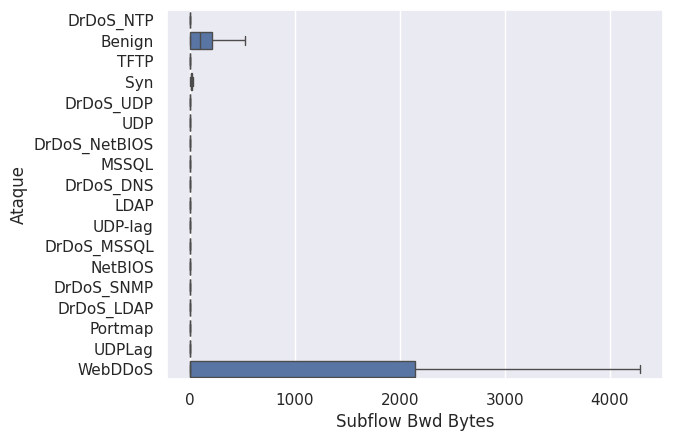

In [ ]:
# Revisión Variables:
List_Same=[i for i in df_CIC2019.columns if "subflow" in i.lower()]
for i in List_Same:
  sns.boxplot(data=df_CIC2019, x=i, y="Label", showfliers=False)
  plt.ylabel("Ataque")
  plt.show()


Por ello, se realizó la construcción de matrices de correlación de acuerdo con el nombre de la variable. Por ejemplo, aquí se presenta el caso de las que contienen `fwd packet length`, donde se ve una alta correlación (Mayor a 0.7) entre todas las variables, a excepción de la desviación estandar:

In [ ]:
List_Same=[i for i in df_CIC2019.columns if "fwd packet length" in i.lower()]
df_CIC2019[List_Same].corr()

Fwd Packet Length Max  Fwd Packet Length Min  \
Fwd Packet Length Max                     1.0                    0.7   
Fwd Packet Length Min                     0.7                    1.0   
Fwd Packet Length Mean                    0.8                    1.0   
Fwd Packet Length Std                     0.5                   -0.2   

                        Fwd Packet Length Mean  Fwd Packet Length Std  
Fwd Packet Length Max                      0.8                    0.5  
Fwd Packet Length Min                      1.0                   -0.2  
Fwd Packet Length Mean                     1.0                   -0.0  
Fwd Packet Length Std                     -0.0                    1.0

Con esto, a partir de la librería de seaborn se construyó un mapa de calor con la lista construida previamente con los elementos en común de las variables:

['Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std']


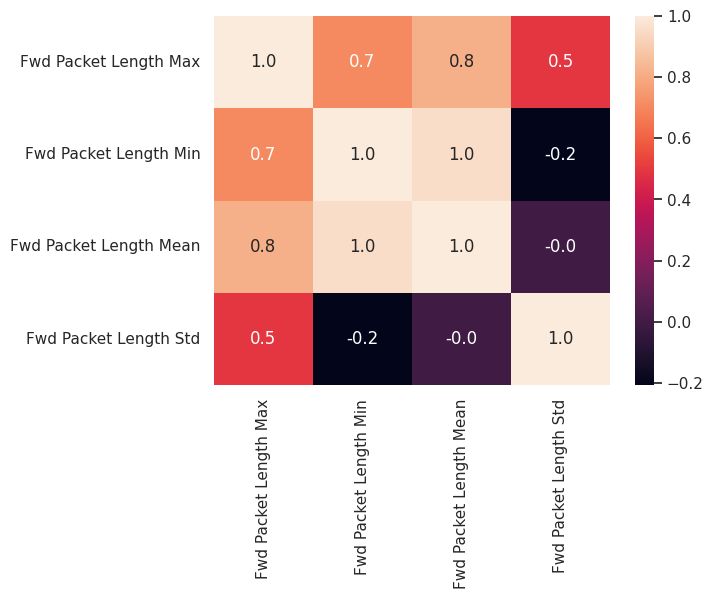

['Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std']


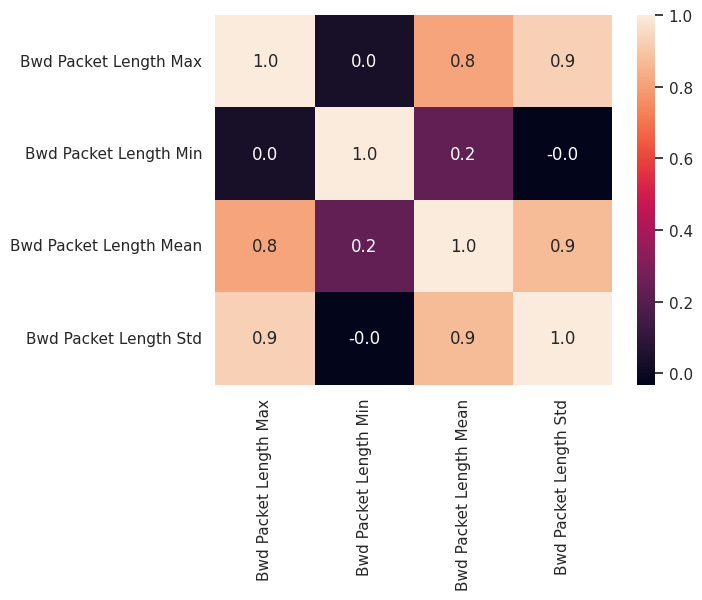

['Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min']


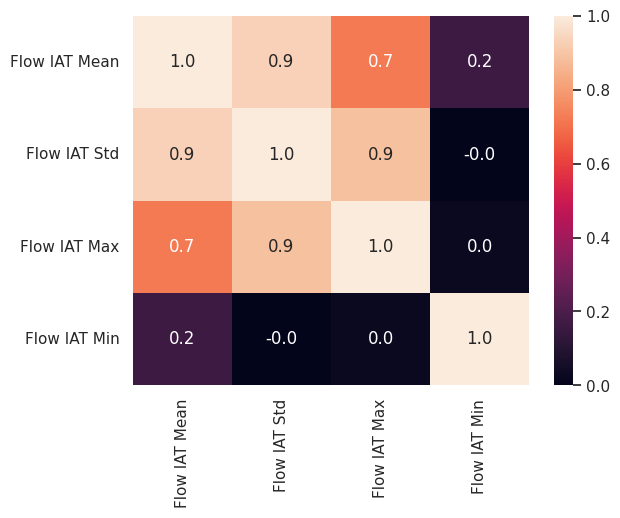

['Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min']


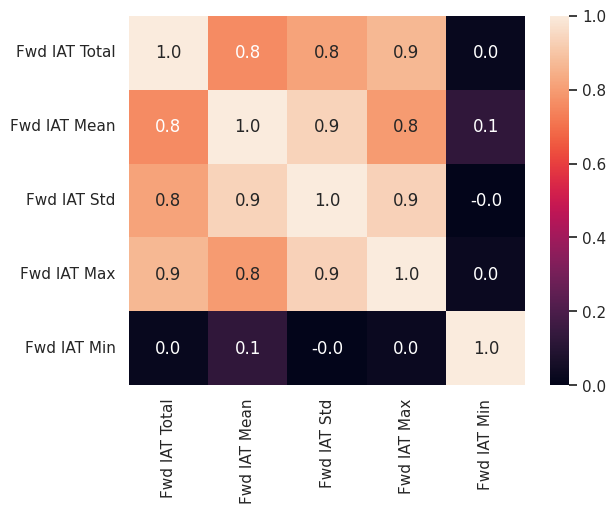

['Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min']


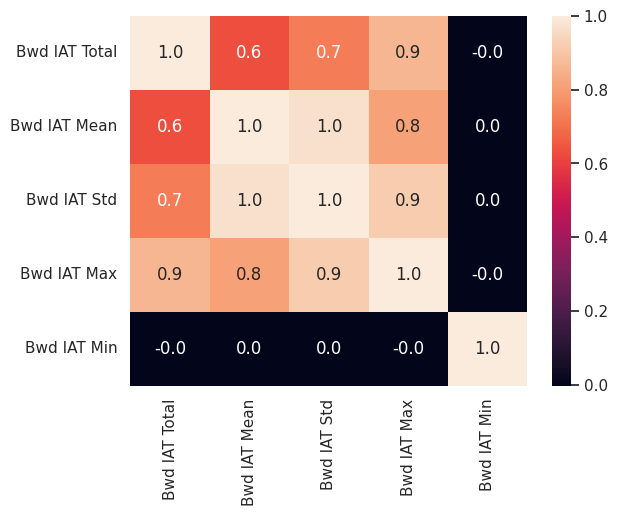

['Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance']


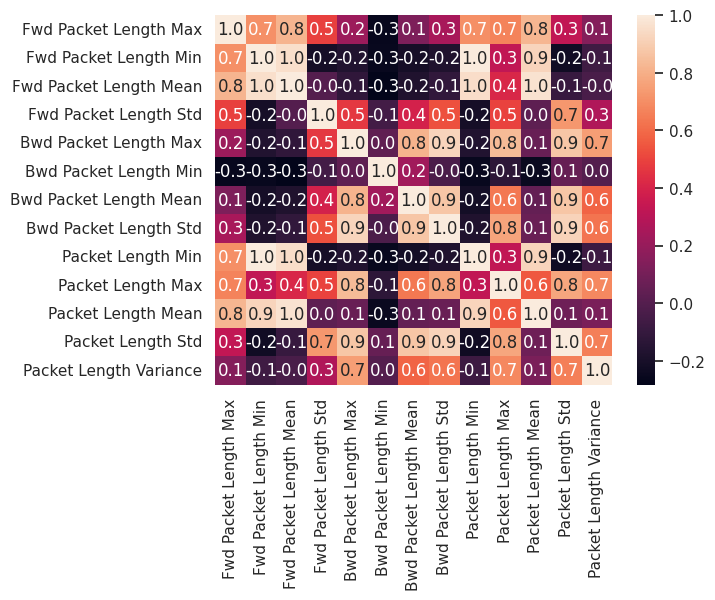

['Fwd Avg Bytes/Bulk', 'Bwd Avg Bytes/Bulk']


/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


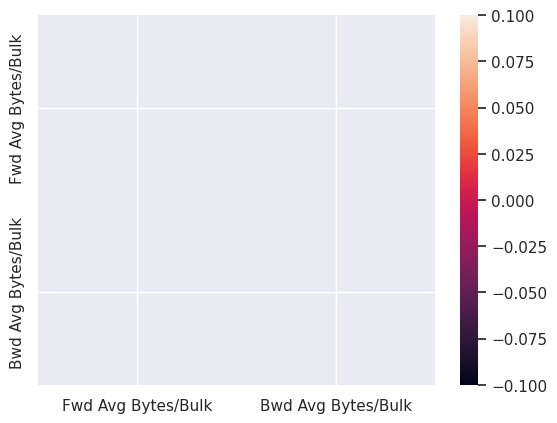

['Fwd Avg Packets/Bulk', 'Bwd Avg Packets/Bulk']


/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


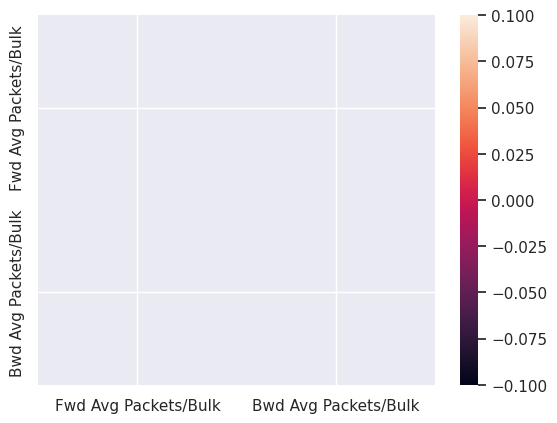

['Active Mean', 'Active Std', 'Active Max', 'Active Min']


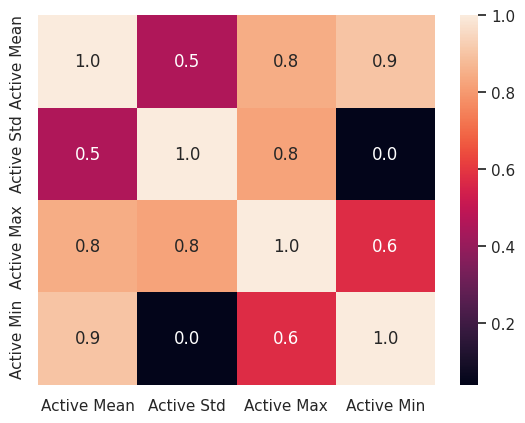

['Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']


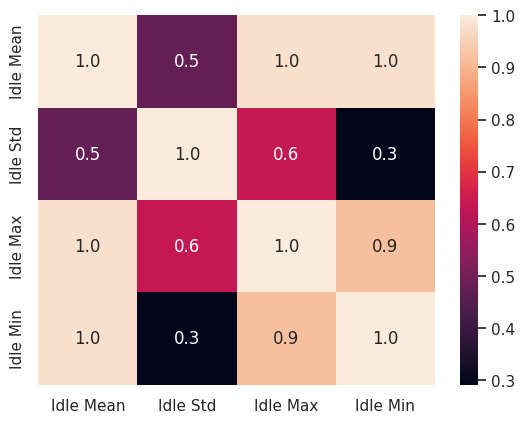

In [ ]:
for j in List_val:
  List_Same=[i for i in df_CIC2019.columns if j in i]
  print(List_Same)
  sns.heatmap(df_CIC2019[List_Same].corr(),annot=True, fmt=".1f")
  plt.show()

A partir de estas gráficas se identifica lo siguiente:

* "Fwd Packet Length": Alta correlación menos en desviación estándar
* "Bwd Packet Length": Alta correlación menos en el valor mínimo
* "Flow IAT": Alta correlación menos en el valor mínimo
* "Fwd IAT": Alta correlación menos en el valor mínimo
* "Bwd IAT": Alta correlación menos en el valor mínimo
* "Packet Length": Al ser la unión de varias variables, se identifica que hay una alta correlación, a excepción de los valores mínimos
* "Bytes/Bulk" y "Packets/Bulk" - Revisión de formato de acuerdo con parámetros de gráfica
* "Active": Alta correlación menos en el valor mínimo
* "Idle": Alta correlación menos en el valor mínimo

Como complemento, se muestra el conteo de los registros por la variable protocolo, donde se evidencia que la mayoría se concentran en el valor de 17

<Axes: xlabel='Protocol', ylabel='Label'>

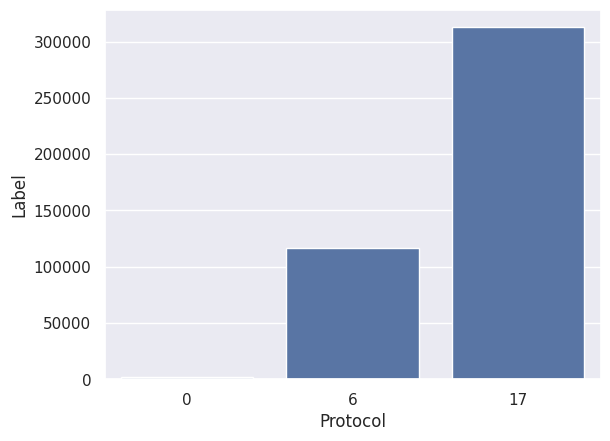

In [ ]:
sns.barplot(data=df_CIC2019.groupby("Protocol").count()["Label"].reset_index(),x="Protocol",y="Label")

De la misma manera, se presenta la cantidad de registros por ataque, donde la mayor parte corresponde a DrDoS_NTP y le siguen los casos benignos:

Text(0, 0.5, 'Conteo')

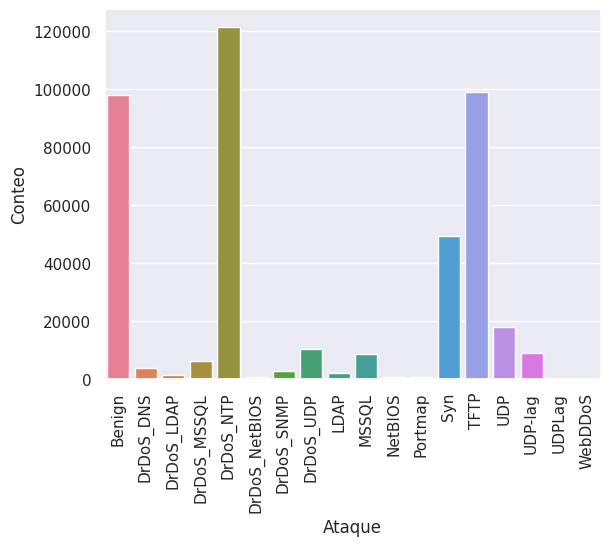

In [ ]:
sns.barplot(data=df_CIC2019.groupby("Label").count()["Protocol"].reset_index(),x="Label",y="Protocol",hue="Label", legend=False)
plt.xticks(rotation=90)
plt.xlabel("Ataque")
plt.ylabel("Conteo")

Finalmente, se presenta la distribución para cada una de las 78 variables disponibles, logrando identificar la presencia de outliers en las medidas y de varias variables donde se presenta una alta cantidad de valores en 0:

In [ ]:
df_CIC2019.describe().iloc[:,[i for i in range(0,15)]]

Protocol  Flow Duration  Total Fwd Packets  Total Backward Packets  \
count  431371.0       431371.0           431371.0                431371.0   
mean       13.9      8404855.9               24.1                     2.5   
std         5.0     21265960.1              195.9                    56.4   
min         0.0            1.0                1.0                     0.0   
25%         6.0          787.0                4.0                     0.0   
50%        17.0        44804.0                4.0                     0.0   
75%        17.0      3002507.5               16.0                     2.0   
max        17.0    119998742.0            86666.0                 31700.0   

       Fwd Packets Length Total  Bwd Packets Length Total  \
count                  431371.0                  431371.0   
mean                     9417.0                    1632.9   
std                     34452.5                  106405.6   
min                         0.0                       0.0   
25%                        78.0                       0.0   
50%                      2064.0                       0.0   
75%                      5160.0                       0.0   
max                  15266416.0                58429504.0   

       Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
count               431371.0               431371.0                431371.0   
mean                   357.5                  294.7                   324.9   
std                    320.0                  273.3                   268.6   
min                      0.0                    0.0                     0.0   
25%                     37.0                    6.0                    32.0   
50%                    440.0                  330.0                   428.0   
75%                    516.0                  516.0                   516.0   
max                  32120.0                 2131.0                  3015.3   

       Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  \
count               431371.0               431371.0               431371.0   
mean                    20.2                   79.6                    8.7   
std                     70.9                  490.7                   32.0   
min                      0.0                    0.0                    0.0   
25%                      0.0                    0.0                    0.0   
50%                      0.0                    0.0                    0.0   
75%                      0.0                    0.0                    0.0   
max                   2221.6                37960.0                 1460.0   

       Bwd Packet Length Mean  Bwd Packet Length Std  Flow Bytes/s  
count                431371.0               431371.0      431371.0  
mean                     25.9                   21.0    73737608.5  
std                     125.6                  128.5   332348361.9  
min                       0.0                    0.0           0.0  
25%                       0.0                    0.0         656.0  
50%                       0.0                    0.0        9818.1  
75%                       0.0                    0.0     8994594.6  
max                    5011.1                 7045.1  2944000000.0

In [ ]:
df_CIC2019.describe().iloc[:,[i for i in range(15,30)]]

Flow Packets/s  Flow IAT Mean  Flow IAT Std  Flow IAT Max  \
count        431371.0       431371.0      431371.0      431371.0   
mean         126688.8       799873.3     1413245.0     3740800.2   
std          414285.0      1603963.5     2799869.2     8985099.0   
min               0.0            0.3           0.0           1.0   
25%               1.3           40.8          52.7         192.0   
50%             128.8         9510.0       13248.6       35418.0   
75%           33460.4      1000233.0     1732005.9     3000610.0   
max         4000000.0     51199892.0    68082928.0   119954416.0   

       Flow IAT Min  Fwd IAT Total  Fwd IAT Mean  Fwd IAT Std  Fwd IAT Max  \
count      431371.0       431371.0      431371.0     431371.0     431371.0   
mean         4322.4      8329522.0      976245.4    1540342.4    3698762.5   
std        238727.0     21258466.0     1994981.9    3177546.0    8969324.0   
min             0.0            0.0           0.0          0.0          0.0   
25%             0.0           73.0           6.0         10.8         47.0   
50%             1.0        10615.0         269.7        659.7       2849.0   
75%             1.0      3001900.0     1000336.3    1732004.0    3000473.0   
max      51199892.0    119998744.0    51199892.0   67905824.0  119954416.0   

       Fwd IAT Min  Bwd IAT Total  Bwd IAT Mean  Bwd IAT Std  Bwd IAT Max  \
count     431371.0       431371.0      431371.0     431371.0     431371.0   
mean        3981.5      3682353.5      431266.5     814155.2    2054229.2   
std       239184.4     16331980.0     1901204.8    3491250.5    8820668.0   
min            0.0            0.0           0.0          0.0          0.0   
25%            0.0            0.0           0.0          0.0          0.0   
50%            1.0            0.0           0.0          0.0          0.0   
75%            1.0            1.0           1.0          0.0          1.0   
max     51199892.0    119943720.0    58961592.0   83384280.0  117923184.0   

       Bwd IAT Min  
count     431371.0  
mean           1.0  
std            5.2  
min            0.0  
25%            0.0  
50%            0.0  
75%            1.0  
max          249.0

In [ ]:
df_CIC2019.describe().iloc[:,[i for i in range(30,45)]]

Fwd PSH Flags  Bwd PSH Flags  Fwd URG Flags  Bwd URG Flags  \
count       431371.0       431371.0       431371.0       431371.0   
mean             0.0            0.0            0.0            0.0   
std              0.2            0.0            0.0            0.0   
min              0.0            0.0            0.0            0.0   
25%              0.0            0.0            0.0            0.0   
50%              0.0            0.0            0.0            0.0   
75%              0.0            0.0            0.0            0.0   
max              1.0            0.0            0.0            0.0   

       Fwd Header Length  Bwd Header Length  Fwd Packets/s  Bwd Packets/s  \
count           431371.0           431371.0       431371.0       431371.0   
mean        -184307400.1         -1139718.8       124939.4         1749.4   
std         4266888506.5         59065169.6       412136.9        32359.7   
min      -212543795000.0     -17003494240.0            0.0            0.0   
25%                 28.0                0.0            1.3            0.0   
50%                 64.0                0.0           64.3            0.0   
75%                200.0               40.0        27141.2            0.1   
max          134480904.0           634024.0      4000000.0      2000000.0   

       Packet Length Min  Packet Length Max  Packet Length Mean  \
count           431371.0           431371.0            431371.0   
mean               294.3              407.2               332.9   
std                272.8              529.9               267.7   
min                  0.0                0.0                 0.0   
25%                  6.0               58.0                43.8   
50%                330.0              440.0               430.0   
75%                516.0              516.0               516.0   
max               1472.0            37960.0              4023.9   

       Packet Length Std  Packet Length Variance  FIN Flag Count  \
count           431371.0                431371.0        431371.0   
mean                32.0                 14998.1             0.0   
std                118.2                204956.5             0.0   
min                  0.0                     0.0             0.0   
25%                  0.0                     0.0             0.0   
50%                  0.0                     0.0             0.0   
75%                 21.4                   456.3             0.0   
max               6616.6              43778892.0             0.0   

       SYN Flag Count  
count        431371.0  
mean              0.0  
std               0.0  
min               0.0  
25%               0.0  
50%               0.0  
75%               0.0  
max               1.0

In [ ]:
df_CIC2019.describe().iloc[:,[i for i in range(45,60)]]

RST Flag Count  PSH Flag Count  ACK Flag Count  URG Flag Count  \
count        431371.0        431371.0        431371.0        431371.0   
mean              0.0             0.0             0.2             0.1   
std               0.2             0.0             0.4             0.3   
min               0.0             0.0             0.0             0.0   
25%               0.0             0.0             0.0             0.0   
50%               0.0             0.0             0.0             0.0   
75%               0.0             0.0             0.0             0.0   
max               1.0             0.0             1.0             1.0   

       CWE Flag Count  ECE Flag Count  Down/Up Ratio  Avg Packet Size  \
count        431371.0        431371.0       431371.0         431371.0   
mean              0.0             0.0            0.2            397.8   
std               0.2             0.0            0.6            362.5   
min               0.0             0.0            0.0              0.0   
25%               0.0             0.0            0.0             54.0   
50%               0.0             0.0            0.0            442.2   
75%               0.0             0.0            0.0            602.0   
max               1.0             0.0           23.0           4025.8   

       Avg Fwd Segment Size  Avg Bwd Segment Size  Fwd Avg Bytes/Bulk  \
count              431371.0              431371.0            431371.0   
mean                  324.9                  25.9                 0.0   
std                   268.6                 125.6                 0.0   
min                     0.0                   0.0                 0.0   
25%                    32.0                   0.0                 0.0   
50%                   428.0                   0.0                 0.0   
75%                   516.0                   0.0                 0.0   
max                  3015.3                5011.1                 0.0   

       Fwd Avg Packets/Bulk  Fwd Avg Bulk Rate  Bwd Avg Bytes/Bulk  \
count              431371.0           431371.0            431371.0   
mean                    0.0                0.0                 0.0   
std                     0.0                0.0                 0.0   
min                     0.0                0.0                 0.0   
25%                     0.0                0.0                 0.0   
50%                     0.0                0.0                 0.0   
75%                     0.0                0.0                 0.0   
max                     0.0                0.0                 0.0   

       Bwd Avg Packets/Bulk  
count              431371.0  
mean                    0.0  
std                     0.0  
min                     0.0  
25%                     0.0  
50%                     0.0  
75%                     0.0  
max                     0.0

In [ ]:
df_CIC2019.describe().iloc[:,[i for i in range(60,75)]]

Bwd Avg Bulk Rate  Subflow Fwd Packets  Subflow Fwd Bytes  \
count           431371.0             431371.0           431371.0   
mean                 0.0                 24.1             9417.0   
std                  0.0                195.9            34452.5   
min                  0.0                  1.0                0.0   
25%                  0.0                  4.0               78.0   
50%                  0.0                  4.0             2064.0   
75%                  0.0                 16.0             5160.0   
max                  0.0              86666.0         15266416.0   

       Subflow Bwd Packets  Subflow Bwd Bytes  Init Fwd Win Bytes  \
count             431371.0           431371.0            431371.0   
mean                   2.5             1632.9              2354.5   
std                   56.4           106405.6              7791.8   
min                    0.0                0.0                -1.0   
25%                    0.0                0.0                -1.0   
50%                    0.0                0.0                -1.0   
75%                    2.0                0.0               250.0   
max                31700.0         58429504.0             65535.0   

       Init Bwd Win Bytes  Fwd Act Data Packets  Fwd Seg Size Min  \
count            431371.0              431371.0          431371.0   
mean                794.5                  21.9       -23154062.9   
std                5346.6                  54.6       155175511.5   
min                  -1.0                   0.0     -1408237563.0   
25%                  -1.0                   1.0               0.0   
50%                  -1.0                   3.0              20.0   
75%                  -1.0                  13.0              20.0   
max               65535.0               18766.0        67240452.0   

       Active Mean  Active Std  Active Max  Active Min   Idle Mean   Idle Std  
count     431371.0    431371.0    431371.0    431371.0    431371.0   431371.0  
mean       33709.1     25637.0     67571.8     18683.6   2449924.2   498326.3  
std       322311.9    222654.3    518373.9    283201.1   7914009.5  2005164.5  
min            0.0         0.0         0.0         0.0         0.0        0.0  
25%            0.0         0.0         0.0         0.0         0.0        0.0  
50%            0.0         0.0         0.0         0.0         0.0        0.0  
75%            0.0         0.0         0.0         0.0         0.0        0.0  
max     40508000.0  21352442.0  45536680.0  40508000.0 119219448.0 69614024.0

In [ ]:
df_CIC2019.describe().iloc[:,[i for i in range(75,77)]]

Idle Max    Idle Min
count    431371.0    431371.0
mean    2971142.2   1993858.8
std     9045327.0   7245560.5
min           0.0         0.0
25%           0.0         0.0
50%           0.0         0.0
75%           0.0         0.0
max   119219448.0 119219448.0

In [ ]:
df_CIC2019.describe(include="O")

Label
count      431371
unique         18
top     DrDoS_NTP
freq       121368

# 3. CIC 2017

Este dataset fue construido con los mismos campos que el previo, por lo que el análisis fue realizado de forma similar, comenzando con el cargue de la base y visión de las variables disponibles:

In [ ]:
df_CIC2017 = pd.read_parquet("/content/drive/MyDrive/Tesis - Machine Learning/Tesis - Machine Learning/B - bases de datos/Análisis Abril 2024/Bases Consolidadas/Total_CIC2017.parquet")

In [ ]:
df_CIC2017.head()

Protocol  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0        17            164                  2                       2   
1         6       10332520                 11                       7   
2         6       85151217                  7                       8   
3        17            205                  2                       2   
4         6         370341                  7                       7   

   Fwd Packets Length Total  Bwd Packets Length Total  Fwd Packet Length Max  \
0                        70                       126                     35   
1                      2060                     11632                    515   
2                       348                     11595                    324   
3                        66                        98                     33   
4                       376                      3788                    201   

   Fwd Packet Length Min  Fwd Packet Length Mean  Fwd Packet Length Std  ...  \
0                     35                    35.0                    0.0  ...   
1                      0                   187.3                  259.8  ...   
2                      0                    49.7                  121.0  ...   
3                     33                    33.0                    0.0  ...   
4                      0                    53.7                   78.7  ...   

   Fwd Seg Size Min  Active Mean  Active Std  Active Max  Active Min  \
0                32          0.0         0.0           0           0   
1                32          0.0         0.0           0           0   
2                20       9998.0         0.0        9998        9998   
3                32          0.0         0.0           0           0   
4                20          0.0         0.0           0           0   

   Idle Mean  Idle Std  Idle Max  Idle Min          Label  
0        0.0       0.0         0         0         Benign  
1        0.0       0.0         0         0  DoS GoldenEye  
2 85000000.0       0.0  85000000  85000000       DoS Hulk  
3        0.0       0.0         0         0         Benign  
4        0.0       0.0         0         0         Benign  

[5 rows x 78 columns]

In [ ]:
df_CIC2017.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Fla

Posteriormente se identifican el total de registros, que son cercanos a los 2 millones 300 mil:

In [ ]:
df_CIC2017.shape

(2313810, 78)

A su vez, se crearon listas con los indicadores para identificar comportamiento característicos de acuerdo con el ataque. Como estas corresponden a variables numéricas se optó por utilizar boxplot. En este primer acercamiento, se escogió no considerar los outliers para ver claramente las tendencias:

In [ ]:
#Variables con varios indicadores
List_val=["Fwd Packet Length","Bwd Packet Length","Flow IAT",
          "Fwd IAT","Bwd IAT","Packet Length","Bytes/Bulk","Packets/Bulk","Active","Idle"]

In [ ]:
List_tot=[i for i in df_CIC2017.columns if "total" in i.lower()]
List_Max=[i for i in df_CIC2017.columns if "max" in i.lower()]
List_Min=[i for i in df_CIC2017.columns if "min" in i.lower()]
List_Mean=[i for i in df_CIC2017.columns if "mean" in i.lower()]

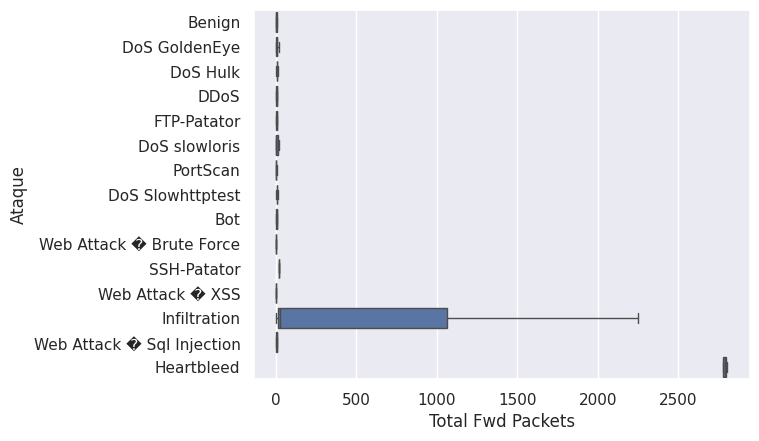

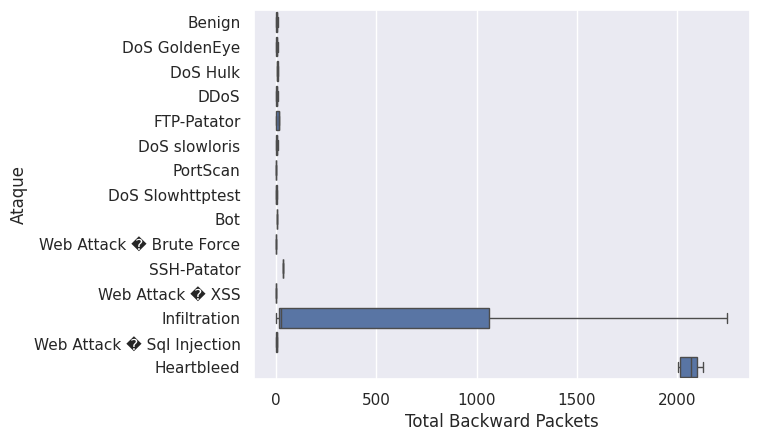

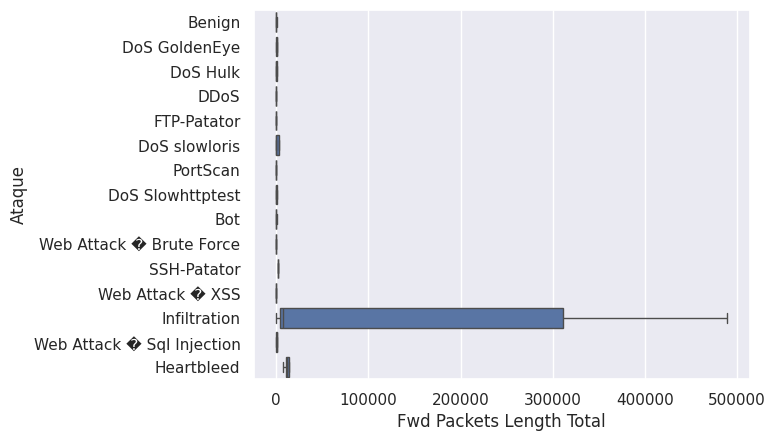

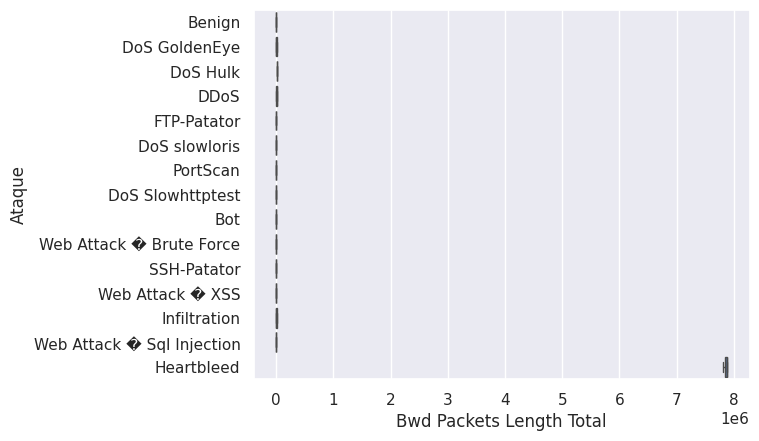

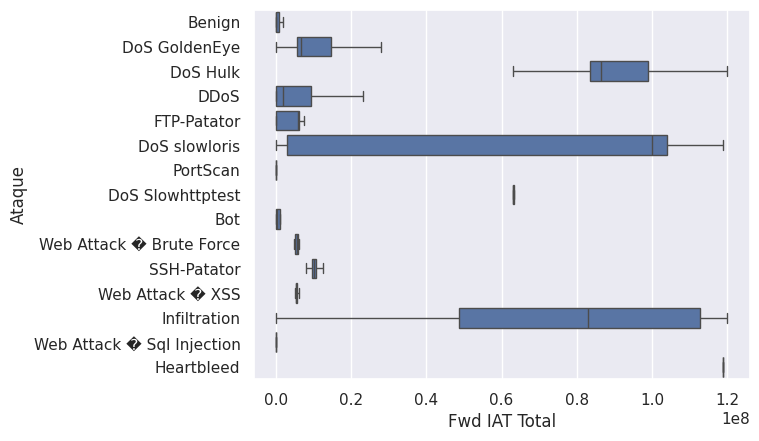

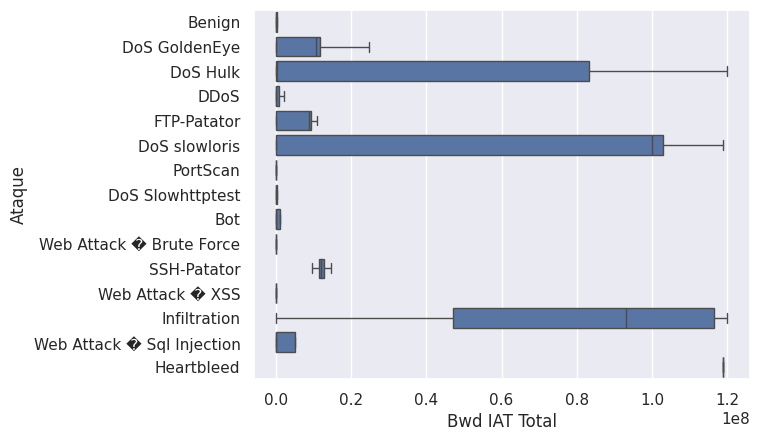

In [ ]:
for i in List_tot:
  sns.set_theme(style="darkgrid")
  sns.boxplot(data=df_CIC2017, x=i, y="Label", showfliers=False)
  plt.ylabel("Ataque")
  plt.show()

Como se identifica en las gráficas, la mayor parte de los ataques presentan valores cercanos a cero en el componente de Packetes, a excepción del ataque de infiltración. En estOS se evidencia la oportunidad de las variables de identificar los diferentes tipos de ataque. Sin embargo, al incluir los outliers es dificil identificar esta tendencia, ya que al momento de gráficar varios de estos la escala no permite mostrar comportamientos diferenciados:

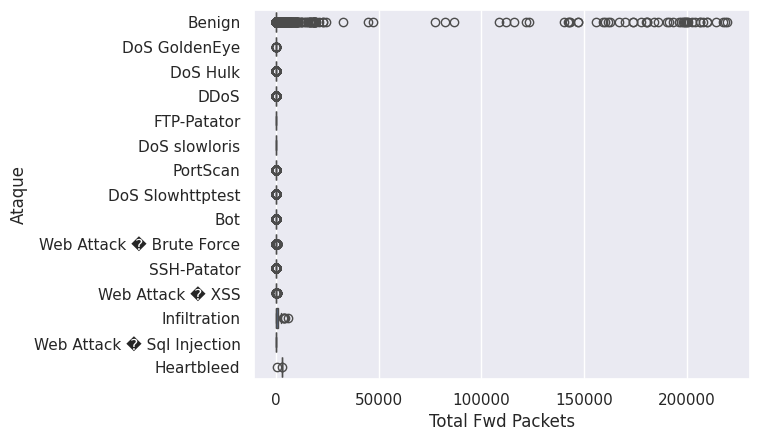

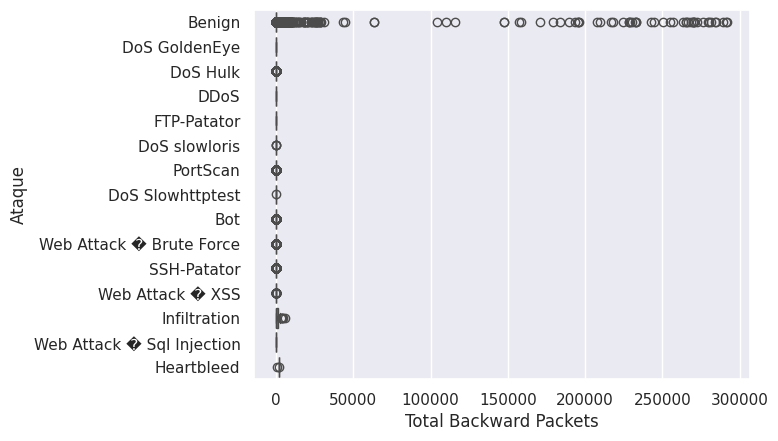

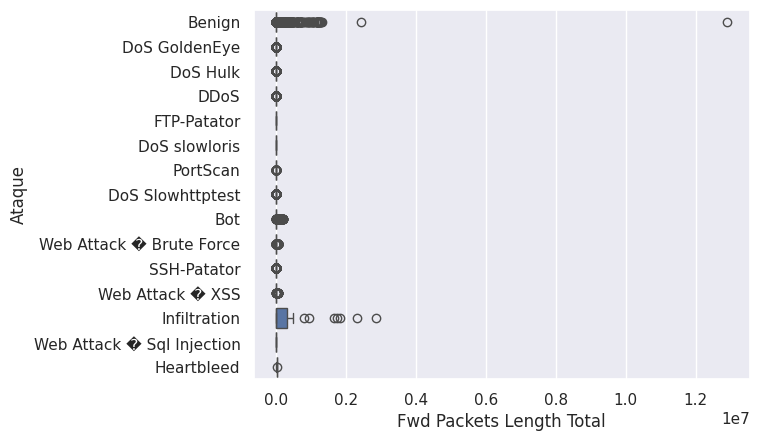

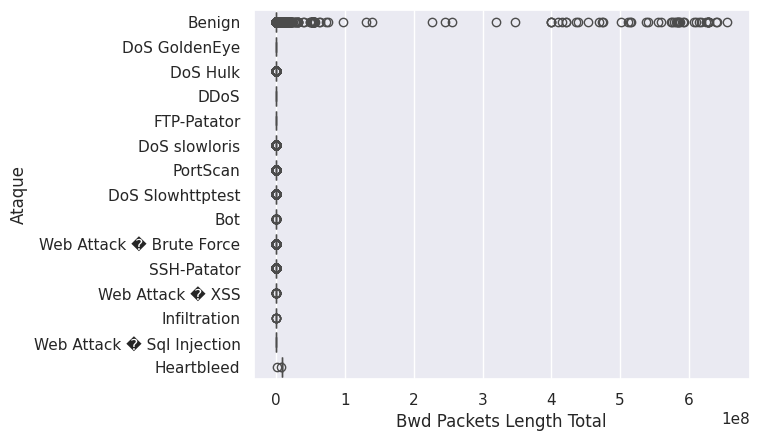

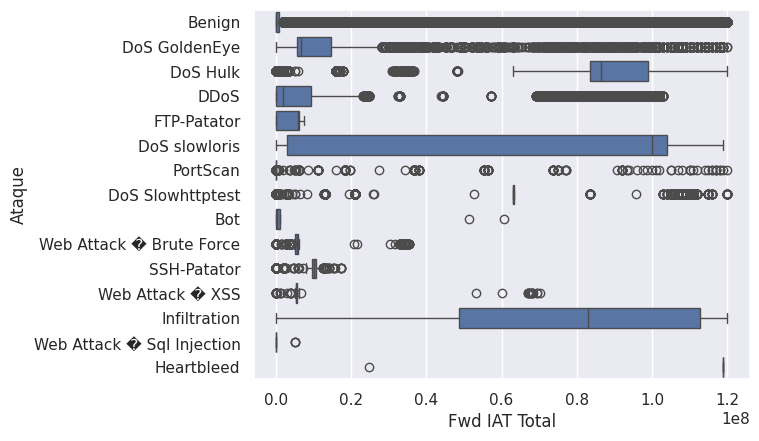

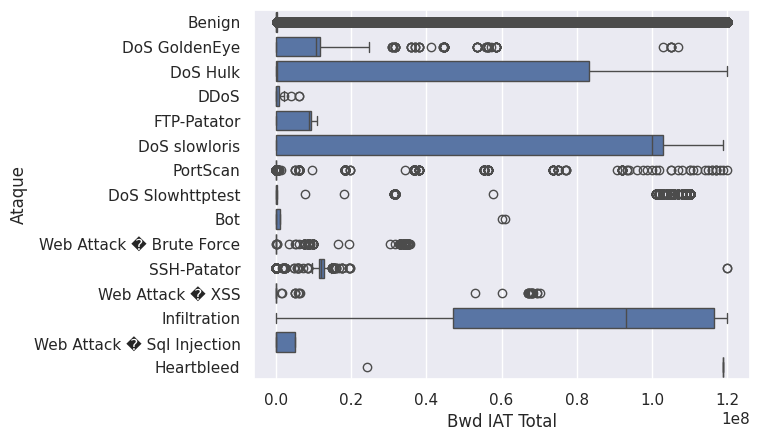

In [ ]:
for i in List_tot:
  sns.set_theme(style="darkgrid")
  sns.boxplot(data=df_CIC2017, x=i, y="Label")
  plt.ylabel("Ataque")
  plt.show()

En los campos etiquetados como máximos, para cada variables se identifica que cada ataque tiene una distribución propia, mientras que en variables como Bwd IAT Max se presentan varios valores con concentración cercana a 0.

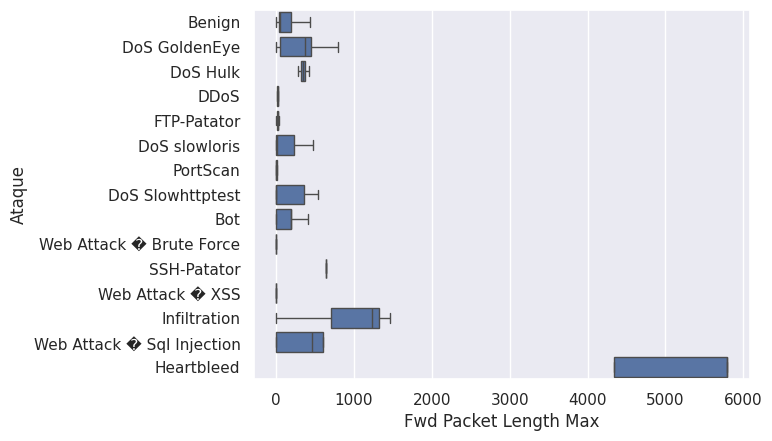

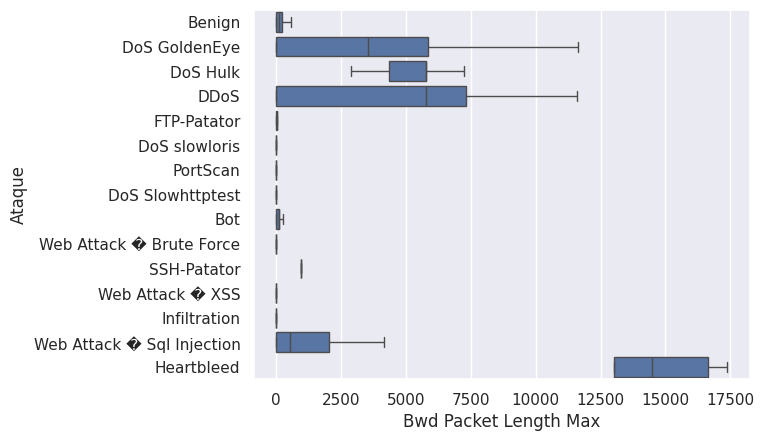

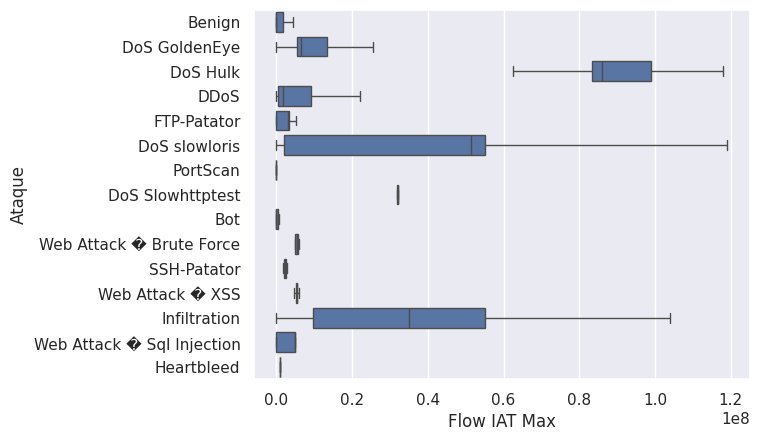

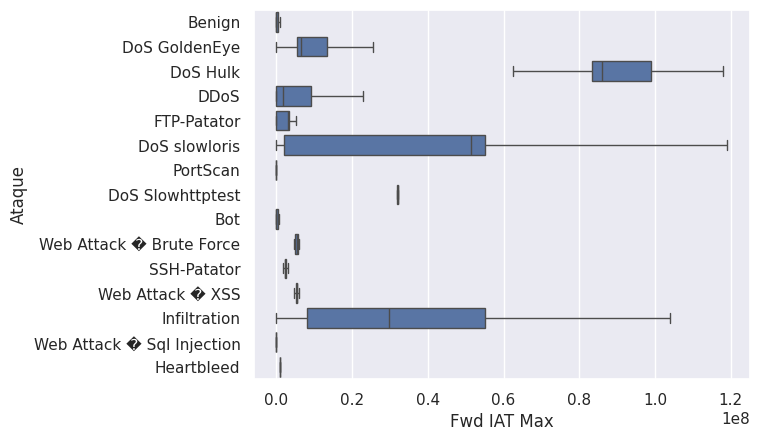

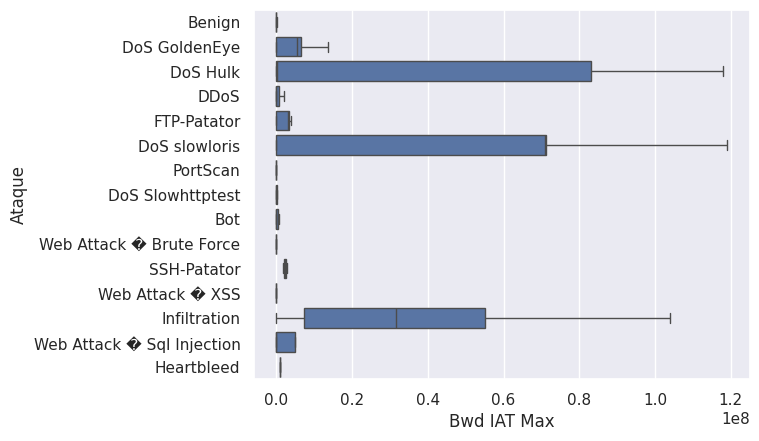

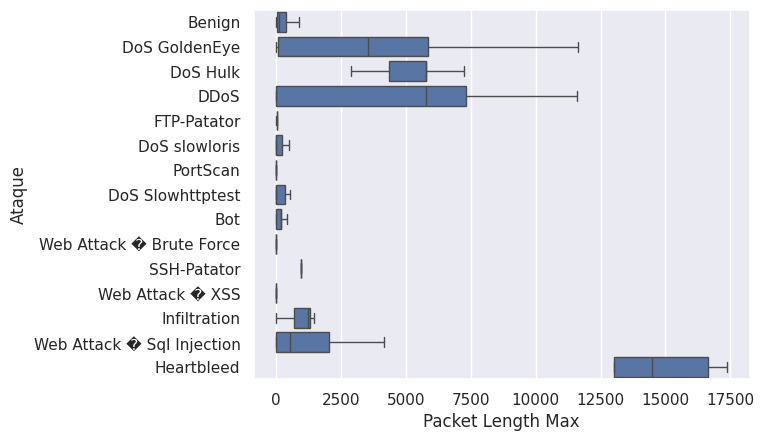

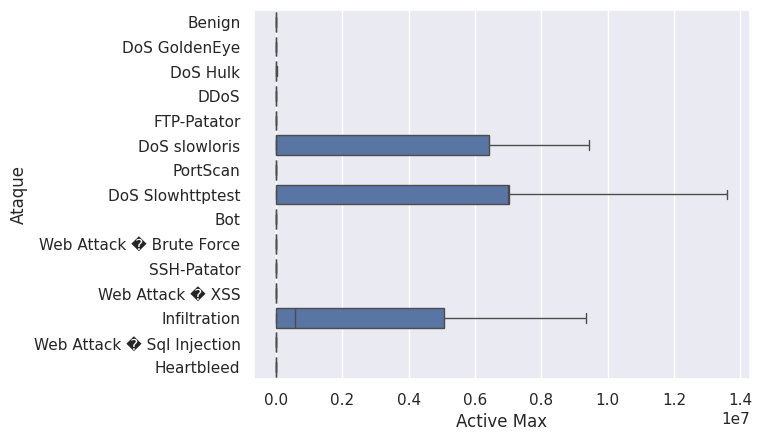

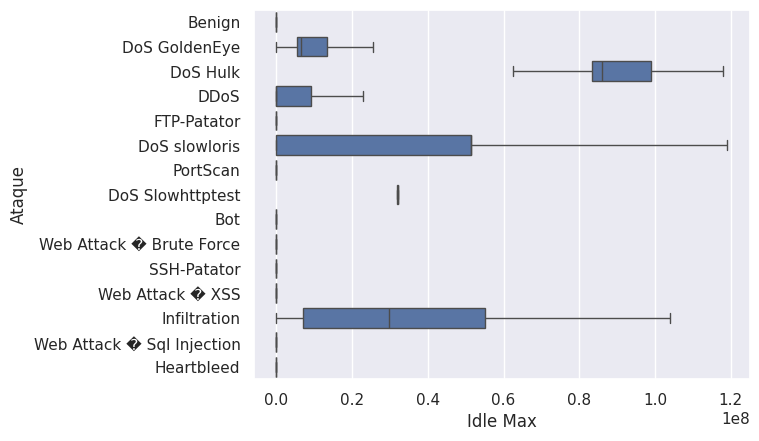

In [ ]:
for i in List_Max:
  sns.boxplot(data=df_CIC2017, x=i, y="Label", showfliers=False)
  plt.ylabel("Ataque")
  plt.show()

En el campo de la Media, los campos se identifican como similares:

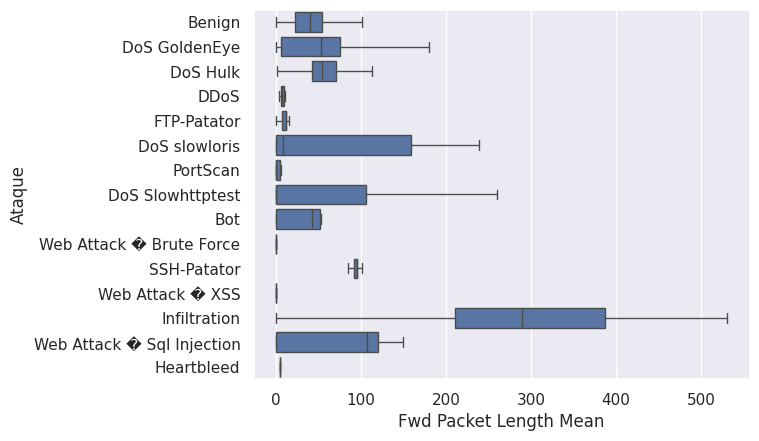

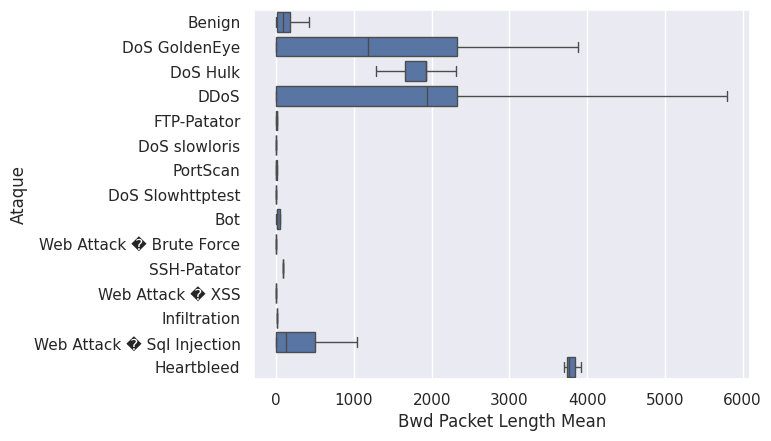

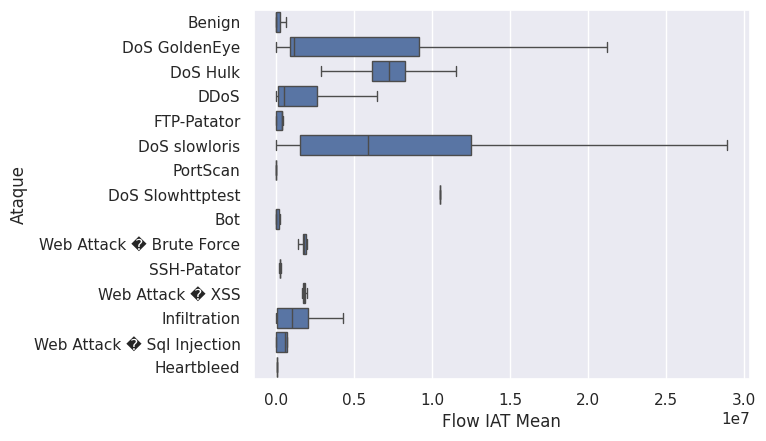

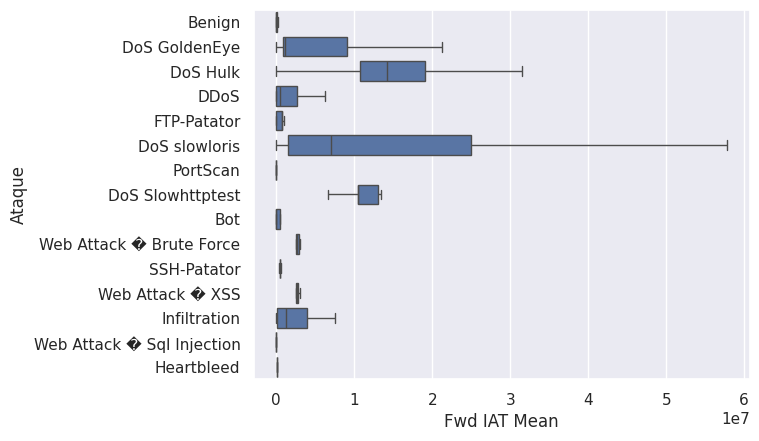

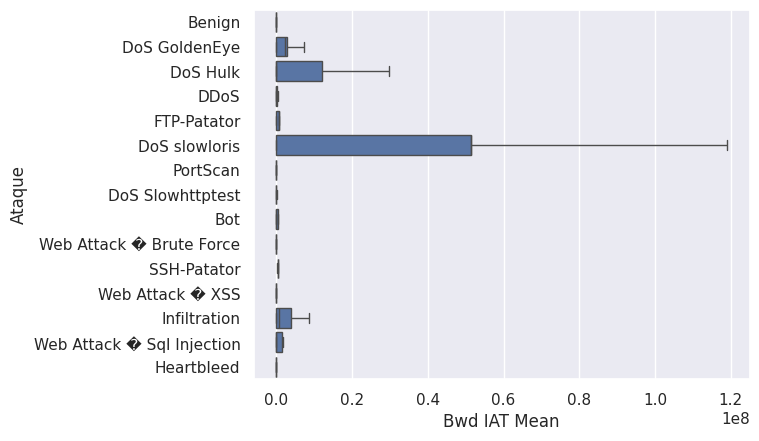

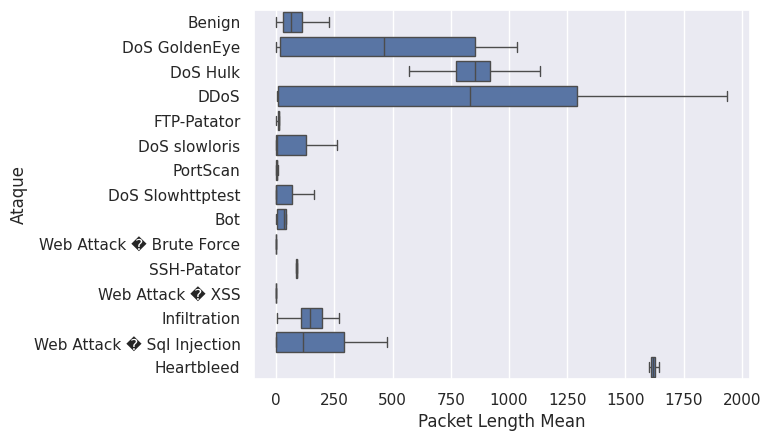

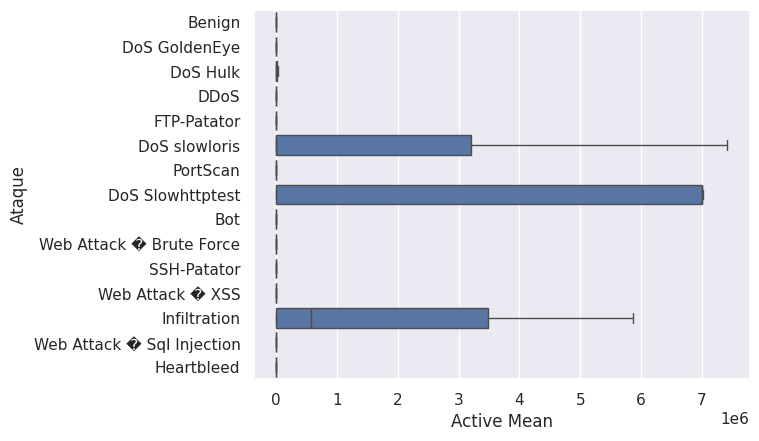

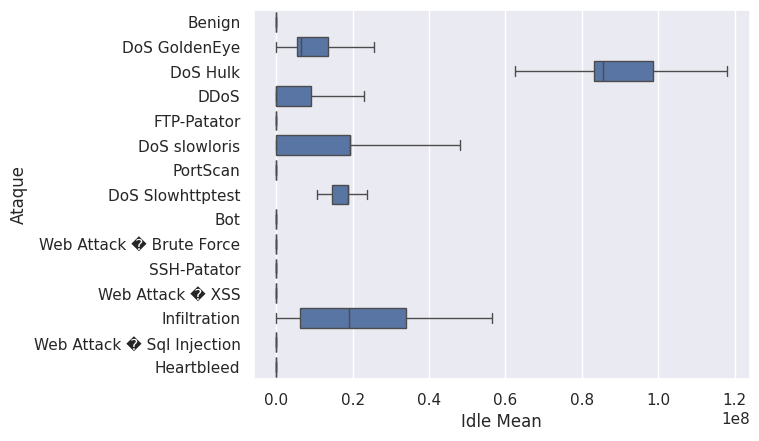

In [ ]:
for i in List_Mean:
  sns.boxplot(data=df_CIC2017, x=i, y="Label", showfliers=False)
  plt.ylabel("Ataque")
  plt.show()

En el caso de comparación de todas las variables ligadas a `Fwd Packet Length` se identifica una correlación entre todas ellas, a expeción deL Mínimo. Por ello, se consideró la realización de un bucle para diagnosticar el comportamiento de los demás:

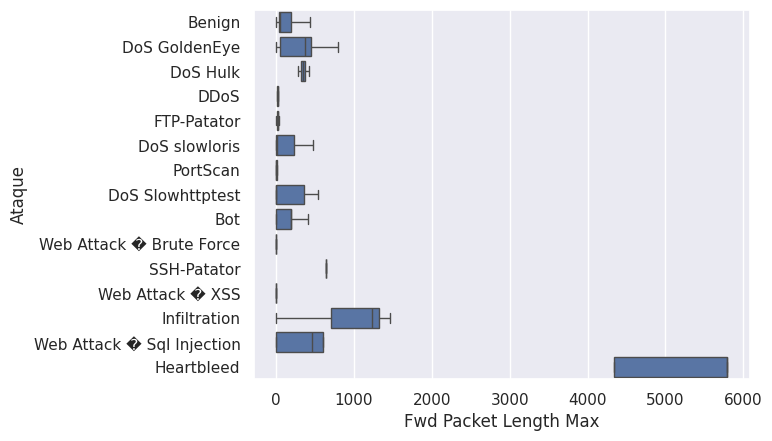

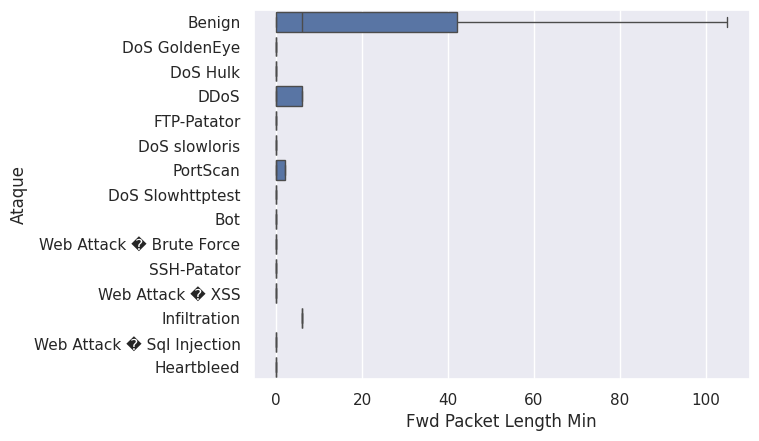

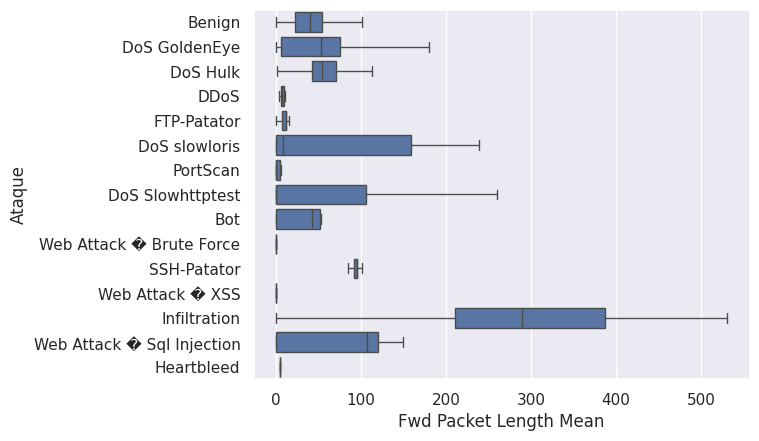

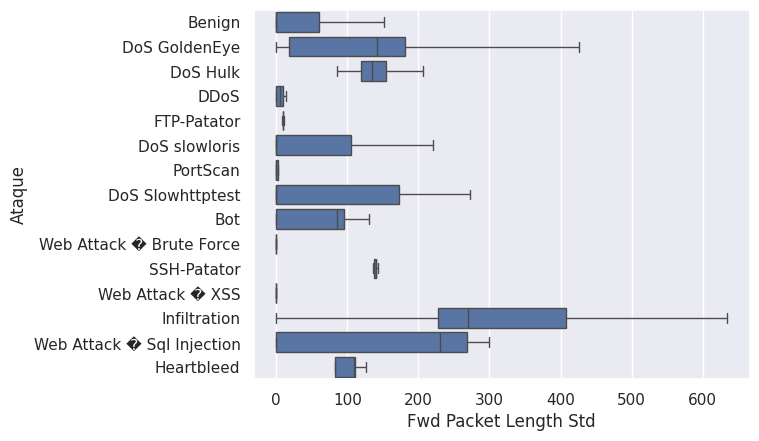

In [ ]:
# Comparación entre variables del mismo nombre:
List_Same=[i for i in df_CIC2017.columns if "fwd packet length" in i.lower()]
for i in List_Same:
  sns.boxplot(data=df_CIC2017, x=i, y="Label", showfliers=False)
  plt.ylabel("Ataque")
  plt.show()

Por ejemplo, en la identificación de correlación en el caso anterior se evidencian valores altos a expeción del mínimo y desviación estandar:

In [ ]:
List_Same=[i for i in df_CIC2017.columns if "fwd packet length" in i.lower()]
df_CIC2017[List_Same].corr()

Fwd Packet Length Max  Fwd Packet Length Min  \
Fwd Packet Length Max                     1.0                   -0.0   
Fwd Packet Length Min                    -0.0                    1.0   
Fwd Packet Length Mean                    0.9                    0.2   
Fwd Packet Length Std                     1.0                   -0.1   

                        Fwd Packet Length Mean  Fwd Packet Length Std  
Fwd Packet Length Max                      0.9                    1.0  
Fwd Packet Length Min                      0.2                   -0.1  
Fwd Packet Length Mean                     1.0                    0.9  
Fwd Packet Length Std                      0.9                    1.0

A partir de ello, se generó un bucle con las principales variables y se comentaron los principales hallazgos:

['Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std']


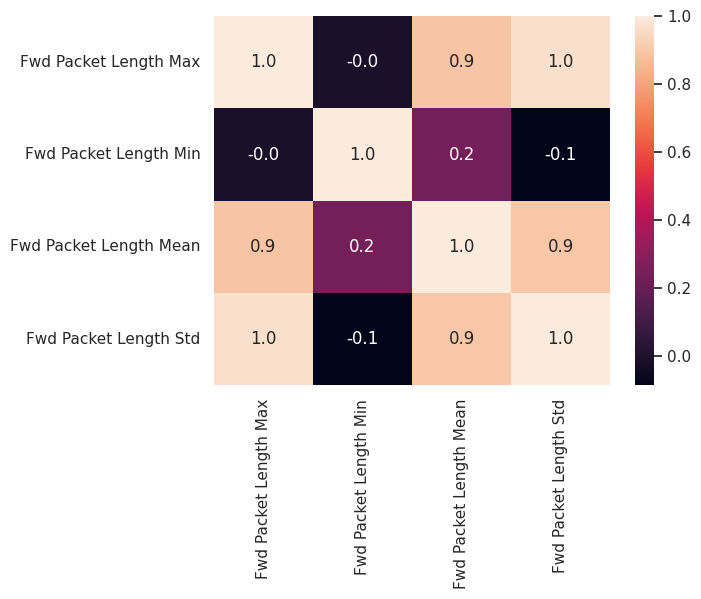

['Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std']


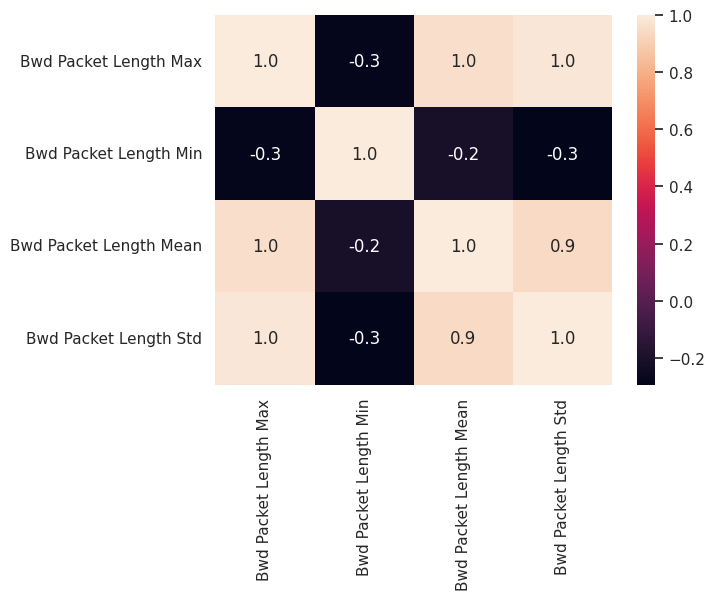

['Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min']


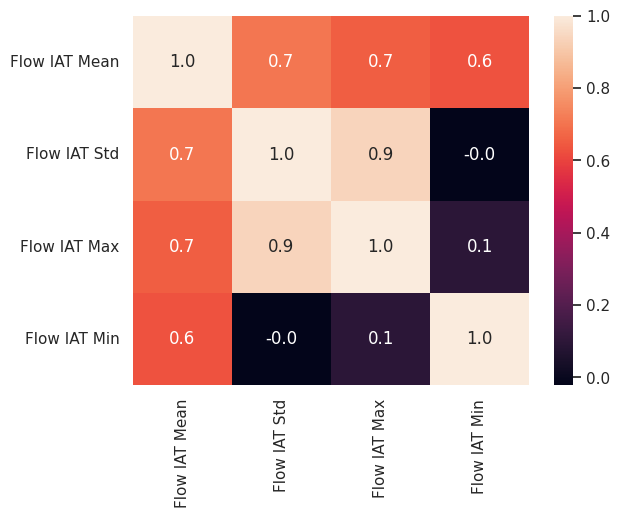

['Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min']


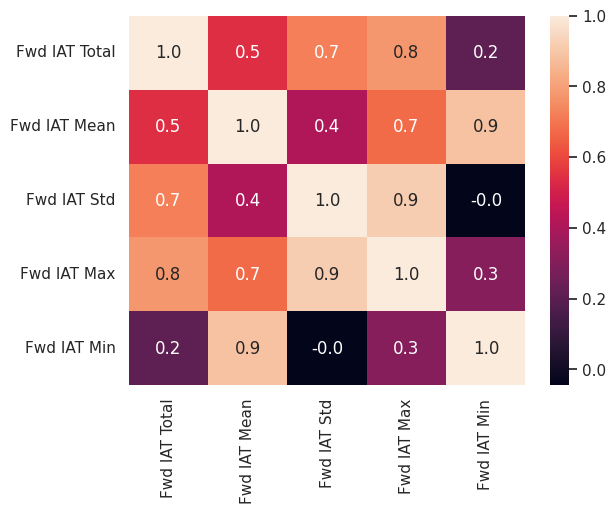

['Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min']


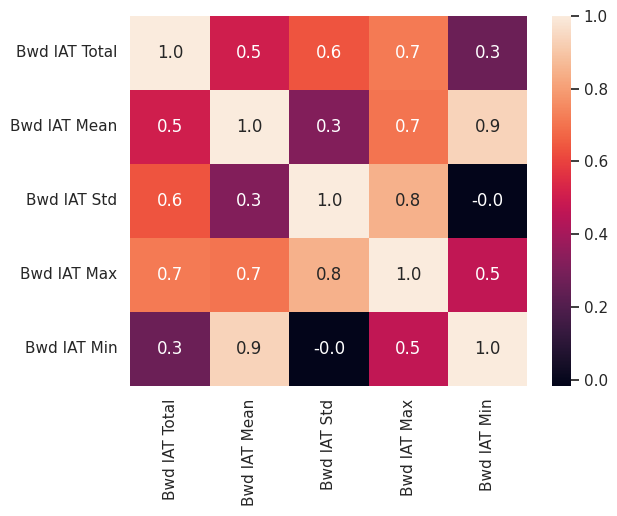

['Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance']


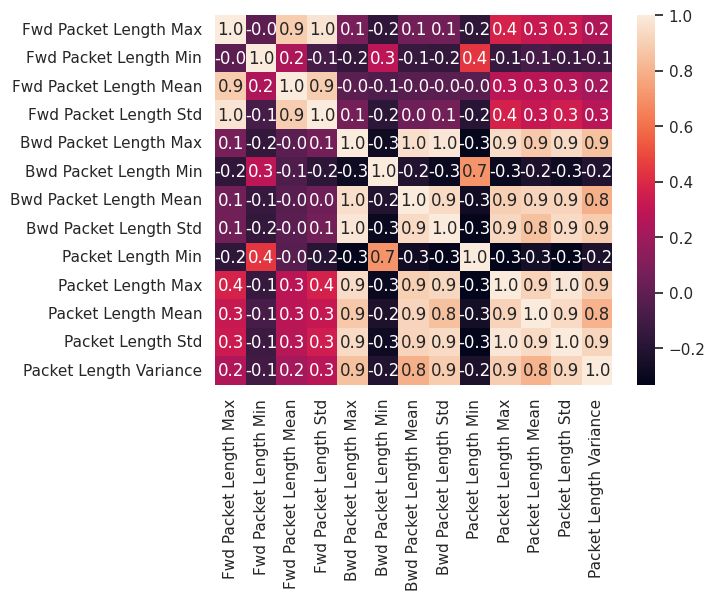

['Fwd Avg Bytes/Bulk', 'Bwd Avg Bytes/Bulk']


/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


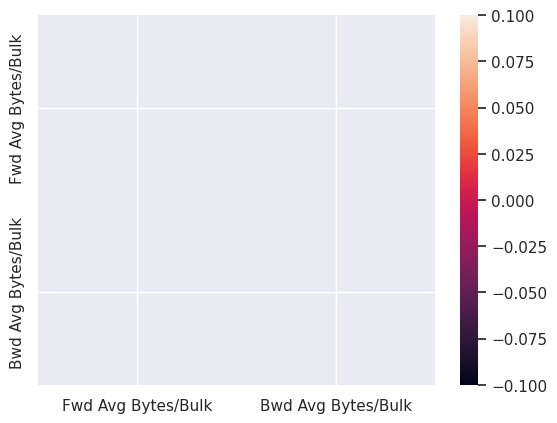

['Fwd Avg Packets/Bulk', 'Bwd Avg Packets/Bulk']


/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


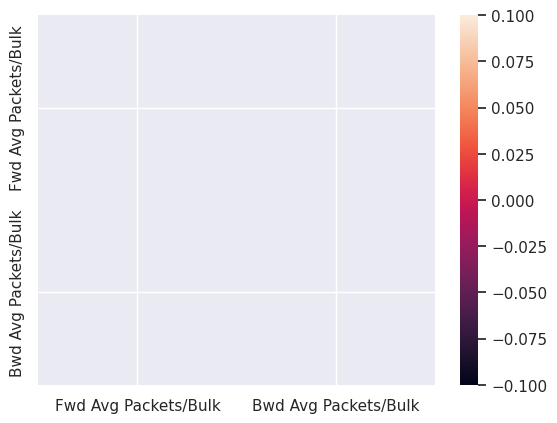

['Active Mean', 'Active Std', 'Active Max', 'Active Min']


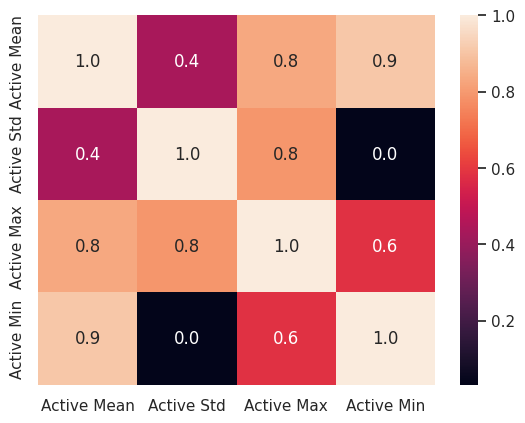

['Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']


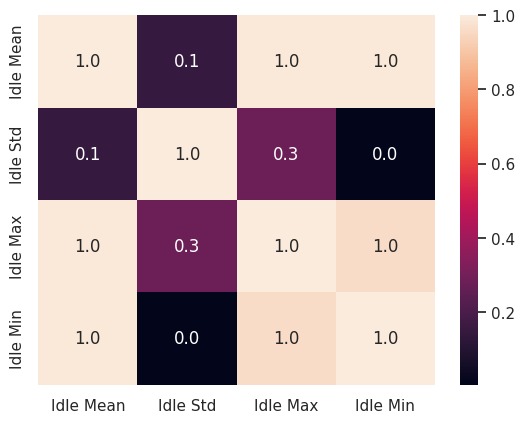

In [ ]:
for j in List_val:
  List_Same=[i for i in df_CIC2017.columns if j in i]
  print(List_Same)
  sns.heatmap(df_CIC2017[List_Same].corr(),annot=True, fmt=".1f")
  plt.show()

* "Fwd Packet Length": Alta correlación menos en el valor mínimo
* "Bwd Packet Length": Alta correlación menos en el valor mínimo
* "Flow IAT": Alta correlación menos en el valor mínimo
* "Fwd IAT": Alta correlación menos en el valor mínimo
* "Bwd IAT": Alta correlación menos en el valor mínimo
* "Packet Length": Al ser la unión de varias variables, se identifica que hay una alta correlación, a excepción de los valores mínimos
* "Bytes/Bulk" y "Packets/Bulk" - Revisión de formato de acuerdo con parámetros de gráfica
* "Active": Alta correlación menos en el valor mínimo
* "Idle": Alta correlación menos en la desviación estándar

Como complemento, se muestra el conteo de los registros por la variable protocolo, donde se evidencia que la mayoría se concentran en el valor de 6

<Axes: xlabel='Protocol', ylabel='Label'>

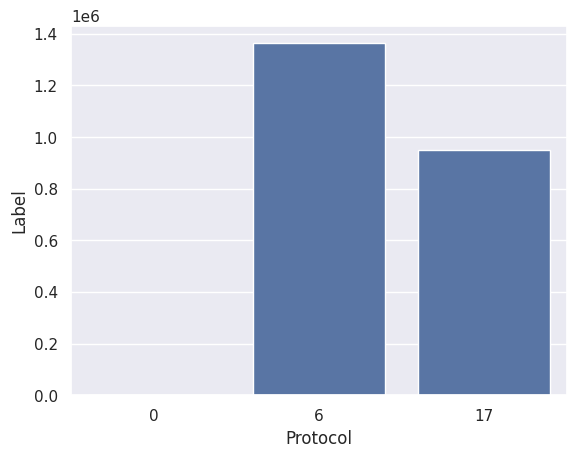

In [ ]:
sns.barplot(data=df_CIC2017.groupby("Protocol").count()["Label"].reset_index(),x="Protocol",y="Label")

A su vez, a diferencia de la base anterior, se muestra que el conteo de valores benignos es mucho mayor con respecto a los demás ataques, aspecto clave ya que este desbalance afectará el desempeño del modelo:

Text(0, 0.5, 'Conteo')

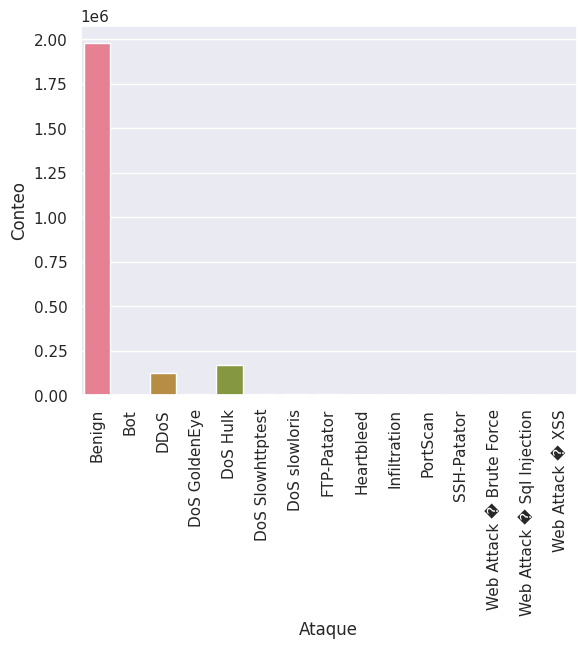

In [ ]:
sns.barplot(data=df_CIC2017.groupby("Label").count()["Protocol"].reset_index(),x="Label",y="Protocol",hue="Label", legend=False)
plt.xticks(rotation=90)
plt.xlabel("Ataque")
plt.ylabel("Conteo")

Como complemento, se presentan las métricas de resumen para cada una de las variables numéricas y categóricas, identificando el efecto de los outliers y de magnitud entre variables:

In [ ]:
df_CIC2017.describe().iloc[:,[i for i in range(0,15)]]

Protocol  Flow Duration  Total Fwd Packets  Total Backward Packets  \
count 2313810.0      2313810.0          2313810.0               2313810.0   
mean       10.5     18075748.3               11.1                    12.6   
std         5.4     36408233.5              829.2                  1103.2   
min         0.0          -13.0                1.0                     0.0   
25%         6.0          476.0                2.0                     1.0   
50%         6.0        64783.0                2.0                     2.0   
75%        17.0      5856947.8                6.0                     5.0   
max        17.0    119999998.0           219759.0                291922.0   

       Fwd Packets Length Total  Bwd Packets Length Total  \
count                 2313810.0                 2313810.0   
mean                      666.4                   19769.8   
std                     11050.1                 2503141.3   
min                         0.0                       0.0   
25%                        37.0                      26.0   
50%                        74.0                     183.0   
75%                       356.0                    2306.0   
max                  12900000.0               655453030.0   

       Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
count              2313810.0              2313810.0               2313810.0   
mean                   250.6                   21.4                    68.8   
std                    785.5                   63.3                   202.3   
min                      0.0                    0.0                     0.0   
25%                     20.0                    0.0                     8.7   
50%                     43.0                    6.0                    39.6   
75%                    274.0                   39.0                    54.0   
max                  24820.0                 2325.0                  5940.9   

       Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  \
count              2313810.0              2313810.0              2313810.0   
mean                    83.0                 1063.2                   48.1   
std                    307.9                 2105.2                   73.2   
min                      0.0                    0.0                    0.0   
25%                      0.0                    6.0                    0.0   
50%                      0.0                  110.0                    0.0   
75%                     85.0                 1349.0                   91.0   
max                   7125.6                19530.0                 2896.0   

       Bwd Packet Length Mean  Bwd Packet Length Std  Flow Bytes/s  
count               2313810.0              2313810.0     2313810.0  
mean                    372.1                  410.2      496887.3  
std                     651.2                  912.1     8071021.8  
min                       0.0                    0.0  -261000000.0  
25%                       6.0                    0.0         119.5  
50%                     101.0                    0.0        3151.6  
75%                     266.0                  440.6       32794.4  
max                    5800.5                 8194.7  2071000000.0

In [ ]:
df_CIC2017.describe().iloc[:,[i for i in range(15,30)]]

Flow Packets/s  Flow IAT Mean  Flow IAT Std  Flow IAT Max  \
count       2313810.0      2313810.0     2313810.0     2313810.0   
mean          20434.2      1575398.6     3571410.5    11220742.8   
std          124280.7      4866184.0     8767385.0    26615965.5   
min        -2000000.0          -13.0           0.0         -13.0   
25%               1.4          294.0           2.1         451.0   
50%              61.5        28117.2       17416.8       59612.0   
75%            5242.5       817201.6     1900254.7     5472982.0   
max         4000000.0    120000000.0    84800264.0   120000000.0   

       Flow IAT Min  Fwd IAT Total  Fwd IAT Mean  Fwd IAT Std  Fwd IAT Max  \
count     2313810.0      2313810.0     2313810.0    2313810.0    2313810.0   
mean       185553.8     17705486.4     3180206.2    3996830.5   11050097.9   
std       3144030.4     36353253.4    10414550.0   10523866.0   26707137.7   
min           -14.0            0.0           0.0          0.0          0.0   
25%             3.0            1.0           1.0          0.0          1.0   
50%             4.0          259.0         214.0          0.0        243.0   
75%            78.0      5542609.8     1013328.3    1754025.4    5231841.0   
max     120000000.0    120000000.0   120000000.0   84602928.0  120000000.0   

       Fwd IAT Min  Bwd IAT Total  Bwd IAT Mean  Bwd IAT Std  Bwd IAT Max  \
count    2313810.0      2313810.0     2313810.0    2313810.0    2313810.0   
mean     1237064.7     12104144.0     2209130.0    1817957.2    5731222.0   
std      9448828.2     31361177.0     9784086.0    6900895.0   18822501.1   
min          -12.0            0.0           0.0          0.0          0.0   
25%            1.0            0.0           0.0          0.0          0.0   
50%            3.0            4.0           4.0          0.0          4.0   
75%           57.0       214410.2       39625.8      48469.7     140168.0   
max    120000000.0    120000000.0   120000000.0   84418016.0  120000000.0   

       Bwd IAT Min  
count    2313810.0  
mean     1183272.1  
std      9176014.2  
min            0.0  
25%            0.0  
50%            3.0  
75%           48.0  
max    120000000.0

In [ ]:
df_CIC2017.describe().iloc[:,[i for i in range(30,45)]]

Fwd PSH Flags  Bwd PSH Flags  Fwd URG Flags  Bwd URG Flags  \
count      2313810.0      2313810.0      2313810.0      2313810.0   
mean             0.0            0.0            0.0            0.0   
std              0.2            0.0            0.0            0.0   
min              0.0            0.0            0.0            0.0   
25%              0.0            0.0            0.0            0.0   
50%              0.0            0.0            0.0            0.0   
75%              0.0            0.0            0.0            0.0   
max              1.0            0.0            1.0            0.0   

       Fwd Header Length  Bwd Header Length  Fwd Packets/s  Bwd Packets/s  \
count          2313810.0          2313810.0      2313810.0      2313810.0   
mean            -31815.6            -2784.9        16066.8         4439.5   
std           23286133.1          1606258.3       113565.2        30464.2   
min       -32212234632.0      -1073741320.0            0.0            0.0   
25%                 40.0               32.0            0.9            0.2   
50%                 64.0               60.0           31.8           16.6   
75%                164.0              136.0         4020.1           93.1   
max            4644908.0          5838440.0      3000000.0      2000000.0   

       Packet Length Min  Packet Length Max  Packet Length Mean  \
count          2313810.0          2313810.0           2313810.0   
mean                18.8             1158.1               207.2   
std                 26.5             2189.6               326.1   
min                  0.0                0.0                 0.0   
25%                  0.0               46.0                29.8   
50%                  6.0              115.0                68.6   
75%                 39.0             1430.0               188.8   
max               1448.0            24820.0              3337.1   

       Packet Length Std  Packet Length Variance  FIN Flag Count  \
count          2313810.0               2313810.0       2313810.0   
mean               359.0                594046.1             0.0   
std                682.1               1804459.4             0.2   
min                  0.0                     0.0             0.0   
25%                  8.8                    76.8             0.0   
50%                 37.5                  1408.3             0.0   
75%                411.4                169209.1             0.0   
max               4731.5              22400000.0             1.0   

       SYN Flag Count  
count       2313810.0  
mean              0.0  
std               0.2  
min               0.0  
25%               0.0  
50%               0.0  
75%               0.0  
max               1.0

In [ ]:
df_CIC2017.describe().iloc[:,[i for i in range(45,60)]]

RST Flag Count  PSH Flag Count  ACK Flag Count  URG Flag Count  \
count       2313810.0       2313810.0       2313810.0       2313810.0   
mean              0.0             0.3             0.3             0.1   
std               0.0             0.4             0.5             0.3   
min               0.0             0.0             0.0             0.0   
25%               0.0             0.0             0.0             0.0   
50%               0.0             0.0             0.0             0.0   
75%               0.0             1.0             1.0             0.0   
max               1.0             1.0             1.0             1.0   

       CWE Flag Count  ECE Flag Count  Down/Up Ratio  Avg Packet Size  \
count       2313810.0       2313810.0      2313810.0        2313810.0   
mean              0.0             0.0            0.7            230.5   
std               0.0             0.0            0.7            352.8   
min               0.0             0.0            0.0              0.0   
25%               0.0             0.0            0.0             35.2   
50%               0.0             0.0            1.0             88.0   
75%               0.0             0.0            1.0            204.4   
max               1.0             1.0          156.0           3893.3   

       Avg Fwd Segment Size  Avg Bwd Segment Size  Fwd Avg Bytes/Bulk  \
count             2313810.0             2313810.0           2313810.0   
mean                   68.8                 372.1                 0.0   
std                   202.3                 651.2                 0.0   
min                     0.0                   0.0                 0.0   
25%                     8.7                   6.0                 0.0   
50%                    39.6                 101.0                 0.0   
75%                    54.0                 266.0                 0.0   
max                  5940.9                5800.5                 0.0   

       Fwd Avg Packets/Bulk  Fwd Avg Bulk Rate  Bwd Avg Bytes/Bulk  \
count             2313810.0          2313810.0           2313810.0   
mean                    0.0                0.0                 0.0   
std                     0.0                0.0                 0.0   
min                     0.0                0.0                 0.0   
25%                     0.0                0.0                 0.0   
50%                     0.0                0.0                 0.0   
75%                     0.0                0.0                 0.0   
max                     0.0                0.0                 0.0   

       Bwd Avg Packets/Bulk  
count             2313810.0  
mean                    0.0  
std                     0.0  
min                     0.0  
25%                     0.0  
50%                     0.0  
75%                     0.0  
max                     0.0

In [ ]:
df_CIC2017.describe().iloc[:,[i for i in range(60,75)]]

Bwd Avg Bulk Rate  Subflow Fwd Packets  Subflow Fwd Bytes  \
count          2313810.0            2313810.0          2313810.0   
mean                 0.0                 11.1              666.4   
std                  0.0                829.2            11035.1   
min                  0.0                  1.0                0.0   
25%                  0.0                  2.0               37.0   
50%                  0.0                  2.0               74.0   
75%                  0.0                  6.0              356.0   
max                  0.0             219759.0         12870338.0   

       Subflow Bwd Packets  Subflow Bwd Bytes  Init Fwd Win Bytes  \
count            2313810.0          2313810.0           2313810.0   
mean                  12.6            19769.3              7250.9   
std                 1103.2          2503107.3             14821.2   
min                    0.0                0.0                -1.0   
25%                    1.0               26.0                -1.0   
50%                    2.0              183.0               229.0   
75%                    5.0             2306.0              8192.0   
max               291922.0        655453030.0             65535.0   

       Init Bwd Win Bytes  Fwd Act Data Packets  Fwd Seg Size Min  \
count           2313810.0             2313810.0         2313810.0   
mean               2133.3                   6.5           -3360.5   
std                8793.2                 703.9         1200083.8   
min                  -1.0                   0.0      -536870661.0   
25%                  -1.0                   0.0              20.0   
50%                  -1.0                   1.0              20.0   
75%                 235.0                   3.0              32.0   
max               65535.0              213557.0             138.0   

       Active Mean  Active Std  Active Max  Active Min   Idle Mean   Idle Std  
count    2313810.0   2313810.0   2313810.0   2313810.0   2313810.0  2313810.0  
mean       99770.9     50324.0    187405.3     71319.8  10172607.0   616408.9  
std       716135.1    434579.5   1131814.3    637582.0  25771430.0  5084448.5  
min            0.0         0.0         0.0         0.0         0.0        0.0  
25%            0.0         0.0         0.0         0.0         0.0        0.0  
50%            0.0         0.0         0.0         0.0         0.0        0.0  
75%            0.0         0.0         0.0         0.0         0.0        0.0  
max    110000000.0  74200000.0 110000000.0 110000000.0 120000000.0 76900000.0

In [ ]:
df_CIC2017.describe().iloc[:,[i for i in range(75,77)]]

Idle Max    Idle Min
count   2313810.0   2313810.0
mean   10637159.0   9688132.7
std    26564407.9  25506700.4
min           0.0         0.0
25%           0.0         0.0
50%           0.0         0.0
75%           0.0         0.0
max   120000000.0 120000000.0

In [ ]:
df_CIC2017.describe(include="O")

Label
count   2313810
unique       15
top      Benign
freq    1977318

# Conclusiones:

A partir de este análisis de bases se identificaron los siguientes aspectos:

* Para el dataseth de BETH se identificaron distintos patrones para poder identificar los ataques, siendo este caso correspondiente a un problema de clasificación binaria

* El dataset de BETH está compuesto principalmente de variables categóricas, lo que hace util la utilización de algoritmos tales como los árboles de decisión

* En los dataset CIC se identificó una amplia gama de variables numéricas, que permiten la clasificación de acuerdo el tipo de ataque

* En CIC2017 se identifica una alta cantidad de registros considerados como benignos en contraste con los malignos, lo que hace importante identificar formas de tratar este desbalance para que no afecte de forma importante el modelo

* Cada base tiene sus puntos fuertes y en contra para su utilización en Modelos de ML, por lo que es clave identificar qué otro tipo de factores afectan y tomar una decisión con respecto a cual es el óptimo